# GradCAM Analysis for VGGFace2-ResNet50 Model in Autism Detection

This notebook implements Gradient-weighted Class Activation Mapping (GradCAM) visualization specifically for the VGGFace2 model with ResNet50 backbone to understand its facial feature focus patterns and potential failure modes in autism spectrum disorder detection.

## Overview
VGGFace2-ResNet50 GradCAM analysis helps us understand:
- **Facial Region Focus**: Which facial areas the model prioritizes for classification
- **Feature Learning Patterns**: How ResNet50 backbone adapts to face-specific features  
- **Failure Mode Detection**: Identifying why the model may misclassify autism cases
- **Architecture Insights**: Understanding ResNet50 performance in facial analysis context
- **Comparison Baseline**: Establishing patterns for comparison with other facial recognition models

## Model Characteristics
- **Backbone**: ResNet50 (50-layer residual network)
- **Training**: VGGFace2 pretraining adapted for autism detection
- **Input Size**: 224x224 pixels
- **Specialty**: Large-scale face recognition with deep residual learning

# 1. Import Libraries and Setup Environment

Import all necessary libraries for GradCAM analysis, VGGFace2 model loading, and facial image visualization.

In [1]:
# Install required packages for GradCAM and face analysis
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
!pip install facenet_pytorch
!pip install --upgrade pillow

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-3rilrp17
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-3rilrp17
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [2]:
# Core libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# GradCAM libraries
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Facial recognition libraries
from facenet_pytorch import InceptionResnetV1
import timm

# Sklearn for metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [3]:
# Environment Configuration for VGGFace2 Analysis
print("Library Versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

# Check PyTorch device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Verify GradCAM import
try:
    from pytorch_grad_cam import GradCAM
    print("✓ GradCAM successfully imported")
except ImportError as e:
    print(f"✗ GradCAM import failed: {e}")

# Configure matplotlib for inline plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Configure seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Configure PyTorch for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✓ Environment configured successfully for VGGFace2 analysis!")

Library Versions:
PyTorch: 2.2.2+cu121
Torchvision: 0.17.2+cu121
NumPy: 1.26.4
Pandas: 2.2.3
Matplotlib: 3.7.2

Device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.1
✓ GradCAM successfully imported
✓ Environment configured successfully for VGGFace2 analysis!


In [4]:
# Global Configuration for VGGFace2 Analysis
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results"  # Local path to trained models
DATA_PATH = "/kaggle/input/autism-image-data/AutismDataset"  # Path to autism dataset
OUTPUT_PATH = "/kaggle/working/"  # Output directory

# VGGFace2 specific configuration
VGGFACE2_INPUT_SIZE = (224, 224)  # Standard VGGFace2 input size
VGGFACE2_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}  # ImageNet normalization

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("VGGFace2 Configuration:")
print(f"Device: {DEVICE}")
print(f"Model path: {MODEL_PATH}")
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Input size: {VGGFACE2_INPUT_SIZE}")
print(f"Normalization: {VGGFACE2_NORMALIZATION}")

# Check if paths exist
if os.path.exists(DATA_PATH):
    print("✓ Dataset path found")
    # Check for test images
    test_path = os.path.join(DATA_PATH, "test")
    if os.path.exists(test_path):
        test_images = glob.glob(os.path.join(test_path, "*.jpg"))
        print(f"✓ Found {len(test_images)} test images")
    else:
        print("⚠️  Test directory not found")
else:
    print("⚠️  Dataset path not found")

VGGFace2 Configuration:
Device: cuda
Model path: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results
Data path: /kaggle/input/autism-image-data/AutismDataset
Output path: /kaggle/working/
Input size: (224, 224)
Normalization: {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
✓ Dataset path found
✓ Found 300 test images


# 2. VGGFace2-ResNet50 Model Architecture Definition

Define the VGGFace2 model class using ResNet50 backbone with face-specific modifications and classification head for autism detection.

In [5]:
class VGGFace2ResNet50(nn.Module):
    """
    VGGFace2 model using ResNet50 backbone for autism detection
    
    This architecture follows the VGGFace2 approach:
    - ResNet50 as feature extractor backbone
    - Face-specific modifications for better facial feature learning
    - Classification head adapted for autism detection (binary classification)
    """
    
    def __init__(self, num_classes=2, pretrained=True, dropout_rate=0.5):
        super(VGGFace2ResNet50, self).__init__()
        
        # Load ResNet50 backbone (same as used in training)
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Remove the final classification layer to use as feature extractor
        self.backbone_features = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Get the number of features from ResNet50
        num_backbone_features = self.backbone.fc.in_features  # 2048 for ResNet50
        
        # Face-specific classification head for autism detection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_backbone_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        # Store architecture info for debugging
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
    def forward(self, x):
        # Extract features using ResNet50 backbone
        features = self.backbone_features(x)
        
        # Flatten features (remove spatial dimensions)
        features = torch.flatten(features, 1)
        
        # Handle batch size = 1 case for batch normalization layers
        # Set model to eval mode during inference to use running stats
        if features.size(0) == 1 and self.training:
            self.eval()
            output = self.classifier(features)
            self.train()  # Restore training mode if it was set
        else:
            output = self.classifier(features)
        
        return output
    
    def get_backbone_features(self, x):
        """Extract features from ResNet50 backbone (useful for analysis)"""
        with torch.no_grad():
            features = self.backbone_features(x)
        return features


def create_vggface2_model(num_classes=2, pretrained=True, dropout_rate=0.5):
    """
    Factory function to create VGGFace2-ResNet50 model
    
    Args:
        num_classes (int): Number of output classes (2 for autism detection)
        pretrained (bool): Whether to use ImageNet pretrained weights
        dropout_rate (float): Dropout rate for regularization
        
    Returns:
        VGGFace2ResNet50: Configured model instance
    """
    model = VGGFace2ResNet50(
        num_classes=num_classes, 
        pretrained=pretrained, 
        dropout_rate=dropout_rate
    )
    
    print(f"✓ VGGFace2-ResNet50 model created")
    print(f"  - Backbone: ResNet50 (pretrained: {pretrained})")
    print(f"  - Classes: {num_classes}")
    print(f"  - Dropout rate: {dropout_rate}")
    print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    return model


# Test model creation
print("Creating VGGFace2-ResNet50 model...")
test_model = create_vggface2_model()

# Test forward pass
print("\nTesting forward pass...")
dummy_input = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    output = test_model(dummy_input)
    print(f"✓ Input shape: {dummy_input.shape}")
    print(f"✓ Output shape: {output.shape}")
    print(f"✓ Model forward pass successful")

print("\nVGGFace2-ResNet50 architecture defined successfully!")

Creating VGGFace2-ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


✓ VGGFace2-ResNet50 model created
  - Backbone: ResNet50 (pretrained: True)
  - Classes: 2
  - Dropout rate: 0.5
  - Total parameters: 26,608,170
  - Trainable parameters: 26,608,170

Testing forward pass...
✓ Input shape: torch.Size([1, 3, 224, 224])
✓ Output shape: torch.Size([1, 2])
✓ Model forward pass successful

VGGFace2-ResNet50 architecture defined successfully!


# 3. Model Loading and Checkpoint Configuration

Load trained VGGFace2 model weights from checkpoint files with proper error handling and state dict management.

In [6]:
def load_vggface2_model(model_path, device=DEVICE, num_classes=2):
    """
    Load trained VGGFace2-ResNet50 model from checkpoint
    
    Args:
        model_path (str): Path to the model checkpoint file
        device (torch.device): Device to load the model on
        num_classes (int): Number of output classes
        
    Returns:
        tuple: (model, success_flag)
    """
    
    print(f"🔧 Loading VGGFace2-ResNet50 model from: {model_path}")
    
    try:
        # Create model architecture (must match training configuration)
        model = VGGFace2ResNet50(num_classes=num_classes, pretrained=True)
        
        # Load checkpoint
        print(f"📂 Loading checkpoint...")
        checkpoint = torch.load(model_path, map_location=device)
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            print(f"📋 Checkpoint keys: {list(checkpoint.keys())}")
            
            if 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
                print("✓ Loading from 'state_dict' key")
            elif 'model' in checkpoint:
                state_dict = checkpoint['model']
                print("✓ Loading from 'model' key")
            elif 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
                print("✓ Loading from 'model_state_dict' key")
            else:
                state_dict = checkpoint
                print("✓ Loading checkpoint as state dict")
        else:
            state_dict = checkpoint
            print("✓ Loading checkpoint directly")
        
        # Load state dict with error handling
        try:
            model.load_state_dict(state_dict, strict=True)
            print("✓ State dict loaded with strict=True")
        except RuntimeError as e:
            print(f"⚠️  Strict loading failed: {e}")
            print("🔄 Attempting non-strict loading...")
            missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
            
            if missing_keys:
                print(f"⚠️  Missing keys: {missing_keys}")
            if unexpected_keys:
                print(f"⚠️  Unexpected keys: {unexpected_keys}")
            
            print("✓ State dict loaded with strict=False")
        
        # Move model to device and set to evaluation mode
        model.to(device)
        model.eval()
        
        print(f"✅ VGGFace2-ResNet50 model loaded successfully")
        print(f"📱 Model moved to device: {device}")
        print(f"🔒 Model set to evaluation mode")
        
        return model, True
        
    except Exception as e:
        print(f"❌ Failed to load VGGFace2 model: {e}")
        print(f"📋 Error type: {type(e).__name__}")
        import traceback
        print(f"🔍 Traceback: {traceback.format_exc()}")
        return None, False


def find_vggface2_model_files(search_paths=None):
    """
    Find VGGFace2 model checkpoint files in specified directories
    
    Args:
        search_paths (list): List of directories to search
        
    Returns:
        list: Found model file paths
    """
    
    if search_paths is None:
        search_paths = [
            MODEL_PATH,
            "/Applications/Projects/ASD_Research/models",
            "/Applications/Projects/ASD_Research",
            "."
        ]
    
    found_models = []
    search_patterns = [
        "*vggface2*.pth",
        "*VGGFace2*.pth", 
        "*resnet50*.pth",
        "*best_vggface2_autism.pth",
        "*vggface*autism*.pth"
    ]
    
    print("🔍 Searching for VGGFace2 model files...")
    
    for search_path in search_paths:
        if os.path.exists(search_path):
            print(f"📁 Searching in: {search_path}")
            
            for pattern in search_patterns:
                files = glob.glob(os.path.join(search_path, pattern))
                found_models.extend(files)
                
                # Also search in subdirectories
                files = glob.glob(os.path.join(search_path, "**", pattern), recursive=True)
                found_models.extend(files)
    
    # Remove duplicates and sort
    found_models = sorted(list(set(found_models)))
    
    print(f"📊 Found {len(found_models)} potential VGGFace2 model files:")
    for i, model_file in enumerate(found_models, 1):
        file_size = os.path.getsize(model_file) / (1024*1024)  # Size in MB
        print(f"  {i}. {os.path.basename(model_file)} ({file_size:.1f} MB)")
        print(f"     Path: {model_file}")
    
    return found_models


# Search for VGGFace2 model files
print("=" * 60)
print("SEARCHING FOR VGGFACE2 MODEL FILES")
print("=" * 60)

vggface2_models = find_vggface2_model_files()

if vggface2_models:
    print(f"\n✅ Found {len(vggface2_models)} VGGFace2 model files")
    selected_model = vggface2_models[0]  # Use the first found model
    print(f"🎯 Selected model: {os.path.basename(selected_model)}")
else:
    print("\n❌ No VGGFace2 model files found")
    print("💡 Please ensure VGGFace2 model checkpoint is available in one of the search directories")
    selected_model = None

SEARCHING FOR VGGFACE2 MODEL FILES
🔍 Searching for VGGFace2 model files...
📁 Searching in: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results
📁 Searching in: .
📊 Found 1 potential VGGFace2 model files:
  1. best_vggface2_autism.pth (94.0 MB)
     Path: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_vggface2_autism.pth

✅ Found 1 VGGFace2 model files
🎯 Selected model: best_vggface2_autism.pth


# 4. Data Preprocessing Pipeline for Face Images

Implement VGGFace2-specific image transforms (224x224 input size) with appropriate normalization for face recognition models.

In [7]:
# VGGFace2-specific image preprocessing pipeline
vggface2_transform = transforms.Compose([
    transforms.Resize(VGGFACE2_INPUT_SIZE),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(
        mean=VGGFACE2_NORMALIZATION['mean'], 
        std=VGGFACE2_NORMALIZATION['std']
    )  # ImageNet normalization (standard for ResNet50)
])

# Alternative transform without normalization for visualization
vggface2_transform_no_norm = transforms.Compose([
    transforms.Resize(VGGFACE2_INPUT_SIZE),
    transforms.ToTensor(),
])


def preprocess_image_vggface2(image_path):
    """
    Load and preprocess image for VGGFace2-ResNet50 model
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        tuple: (input_tensor, original_image_normalized)
    """
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        print(f"📷 Loaded image: {os.path.basename(image_path)}")
        print(f"   Original size: {image.size}")
        
        # Create normalized version for visualization overlay
        original_resized = image.resize(VGGFACE2_INPUT_SIZE)
        original_image = np.array(original_resized) / 255.0  # Normalize to [0,1] for GradCAM
        
        # Apply VGGFace2 transforms for model input
        input_tensor = vggface2_transform(image).unsqueeze(0)  # Add batch dimension
        
        print(f"✓ Preprocessed for VGGFace2:")
        print(f"   Input tensor shape: {input_tensor.shape}")
        print(f"   Original image shape: {original_image.shape}")
        print(f"   Input range: [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")
        print(f"   Original range: [{original_image.min():.3f}, {original_image.max():.3f}]")
        
        return input_tensor, original_image
        
    except Exception as e:
        print(f"❌ Error preprocessing image {image_path}: {e}")
        return None, None


def denormalize_vggface2_tensor(tensor):
    """
    Denormalize VGGFace2 tensor back to [0,1] range for visualization
    
    Args:
        tensor (torch.Tensor): Normalized tensor from VGGFace2 preprocessing
        
    Returns:
        torch.Tensor: Denormalized tensor
    """
    mean = torch.tensor(VGGFACE2_NORMALIZATION['mean']).view(3, 1, 1)
    std = torch.tensor(VGGFACE2_NORMALIZATION['std']).view(3, 1, 1)
    
    # Clone tensor to avoid in-place operations
    tensor = tensor.clone()
    
    # Denormalize: x = (x * std) + mean
    for t, m, s in zip(tensor, mean.flatten(), std.flatten()):
        t.mul_(s).add_(m)
    
    # Clamp to valid range
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor


def load_test_images_autism_dataset(num_images=10):
    """
    Load test images from autism dataset for GradCAM analysis
    
    Args:
        num_images (int): Maximum number of images to load
        
    Returns:
        tuple: (autistic_images, non_autistic_images)
    """
    test_path = os.path.join(DATA_PATH, "test")
    
    if not os.path.exists(test_path):
        print(f"❌ Test directory not found: {test_path}")
        return [], []
    
    # Find images with class labels in filename
    all_test_images = glob.glob(os.path.join(test_path, "*.jpg"))
    
    autistic_images = [img for img in all_test_images if 'Autistic.' in os.path.basename(img)]
    non_autistic_images = [img for img in all_test_images if 'Non_Autistic.' in os.path.basename(img)]
    
    # Limit number of images
    autistic_images = autistic_images[:num_images//2]
    non_autistic_images = non_autistic_images[:num_images//2]
    
    print(f"📊 Loaded test images:")
    print(f"   Autistic: {len(autistic_images)}")
    print(f"   Non-Autistic: {len(non_autistic_images)}")
    print(f"   Total: {len(autistic_images) + len(non_autistic_images)}")
    
    return autistic_images, non_autistic_images


# Test preprocessing pipeline
print("=" * 60)
print("TESTING VGGFACE2 PREPROCESSING PIPELINE")
print("=" * 60)

# Load test images
autistic_imgs, non_autistic_imgs = load_test_images_autism_dataset(num_images=4)

if autistic_imgs or non_autistic_imgs:
    # Test preprocessing on first available image
    test_image = autistic_imgs[0] if autistic_imgs else non_autistic_imgs[0]
    
    print(f"\n🧪 Testing preprocessing on: {os.path.basename(test_image)}")
    input_tensor, original_image = preprocess_image_vggface2(test_image)
    
    if input_tensor is not None:
        print("✅ Preprocessing pipeline working correctly")
        
        # Test denormalization
        denorm_tensor = denormalize_vggface2_tensor(input_tensor[0])
        print(f"✓ Denormalization test: range [{denorm_tensor.min():.3f}, {denorm_tensor.max():.3f}]")
    else:
        print("❌ Preprocessing pipeline failed")
else:
    print("⚠️  No test images found for preprocessing test")

TESTING VGGFACE2 PREPROCESSING PIPELINE
📊 Loaded test images:
   Autistic: 2
   Non-Autistic: 2
   Total: 4

🧪 Testing preprocessing on: Non_Autistic.111.jpg
📷 Loaded image: Non_Autistic.111.jpg
   Original size: (176, 229)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-2.084, 2.623]
   Original range: [0.000, 1.000]
✅ Preprocessing pipeline working correctly
✓ Denormalization test: range [0.000, 0.996]


# 5. GradCAM Implementation for VGGFace2

Create enhanced GradCAM analyzer class specifically optimized for VGGFace2 architecture with ResNet50 backbone compatibility.

In [8]:
class VGGFace2GradCAMAnalyzer:
    """
    Enhanced GradCAM analyzer specifically designed for VGGFace2-ResNet50 models
    """
    
    def __init__(self, model, target_layer, device=DEVICE):
        """
        Initialize VGGFace2 GradCAM analyzer
        
        Args:
            model: VGGFace2-ResNet50 model
            target_layer: Layer for GradCAM visualization
            device: Computation device
        """
        self.model = model
        self.target_layer = target_layer
        self.device = device
        
        # Initialize GradCAM
        self.cam = GradCAM(model=model, target_layers=[target_layer])
        
        print(f"🔬 VGGFace2 GradCAM Analyzer initialized")
        print(f"   Model: {type(model).__name__}")
        print(f"   Target layer: {type(target_layer).__name__}")
        print(f"   Device: {device}")
    
    def generate_gradcam(self, input_tensor, target_class=None, original_image=None):
        """
        Generate GradCAM visualization for input image
        
        Args:
            input_tensor: Preprocessed input tensor
            target_class: Target class for visualization (0=Non-Autistic, 1=Autistic)
            original_image: Original image for overlay
            
        Returns:
            dict: Analysis results including prediction, confidence, and visualizations
        """
        try:
            # Move input to device
            input_tensor = input_tensor.to(self.device)
            
            # Get model prediction
            with torch.no_grad():
                output = self.model(input_tensor)
                prediction_probs = torch.softmax(output, dim=1)
                predicted_class = torch.argmax(prediction_probs, dim=1).item()
                confidence = torch.max(prediction_probs, dim=1)[0].item()
            
            # Use predicted class if target not specified
            if target_class is None:
                target_class = predicted_class
            
            print(f"🎯 VGGFace2 Analysis:")
            print(f"   Predicted class: {predicted_class} ({'Autistic' if predicted_class == 1 else 'Non-Autistic'})")
            print(f"   Confidence: {confidence:.3f}")
            print(f"   Generating GradCAM for class: {target_class}")
            
            # Generate GradCAM
            targets = [ClassifierOutputTarget(target_class)]
            grayscale_cam = self.cam(input_tensor=input_tensor, targets=targets)
            
            # Get the first (and only) image from batch
            grayscale_cam = grayscale_cam[0, :]
            
            # Create visualization overlay
            if original_image is not None:
                visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
            else:
                # Use denormalized tensor if no original image
                rgb_img = denormalize_vggface2_tensor(input_tensor[0]).permute(1, 2, 0).cpu().numpy()
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            print(f"✅ GradCAM generation successful")
            print(f"   Heatmap shape: {grayscale_cam.shape}")
            print(f"   Heatmap range: [{grayscale_cam.min():.3f}, {grayscale_cam.max():.3f}]")
            
            return {
                'prediction': predicted_class,
                'confidence': confidence,
                'target_class': target_class,
                'grayscale_cam': grayscale_cam,
                'visualization': visualization,
                'prediction_probs': prediction_probs.cpu().numpy(),
                'success': True
            }
            
        except Exception as e:
            print(f"❌ VGGFace2 GradCAM generation failed: {e}")
            import traceback
            print(f"🔍 Traceback: {traceback.format_exc()}")
            
            return {
                'prediction': 0,
                'confidence': 0.5,
                'target_class': target_class or 0,
                'grayscale_cam': np.zeros((224, 224)),
                'visualization': np.zeros((224, 224, 3)),
                'prediction_probs': np.array([[0.5, 0.5]]),
                'success': False,
                'error': str(e)
            }
    
    def analyze_image(self, image_path, save_results=True):
        """
        Complete analysis of a single image with both class visualizations
        
        Args:
            image_path: Path to image file
            save_results: Whether to save visualization results
            
        Returns:
            dict: Complete analysis results
        """
        print(f"\n🖼️  VGGFace2 Analysis: {os.path.basename(image_path)}")
        print("-" * 60)
        
        try:
            # Preprocess image
            input_tensor, original_image = preprocess_image_vggface2(image_path)
            
            if input_tensor is None:
                return {'success': False, 'error': 'Preprocessing failed'}
            
            # Generate GradCAM for both classes
            results = {}
            
            # Analysis for Non-Autistic class (class 0)
            print(f"\n🔍 Generating GradCAM for Non-Autistic class...")
            results['non_autistic'] = self.generate_gradcam(
                input_tensor, target_class=0, original_image=original_image
            )
            
            # Analysis for Autistic class (class 1)
            print(f"\n🔍 Generating GradCAM for Autistic class...")
            results['autistic'] = self.generate_gradcam(
                input_tensor, target_class=1, original_image=original_image
            )
            
            # Store overall results
            results['image_path'] = image_path
            results['input_tensor'] = input_tensor
            results['original_image'] = original_image
            results['overall_prediction'] = results['non_autistic']['prediction']
            results['overall_confidence'] = results['non_autistic']['confidence']
            results['success'] = results['non_autistic']['success'] and results['autistic']['success']
            
            # Save results if requested
            if save_results and results['success']:
                self.save_analysis_results(image_path, results)
            
            return results
            
        except Exception as e:
            print(f"❌ VGGFace2 image analysis failed: {e}")
            return {
                'success': False,
                'error': str(e),
                'image_path': image_path
            }
    
    def save_analysis_results(self, image_path, results):
        """
        Save GradCAM analysis results with visualization
        
        Args:
            image_path: Original image path
            results: Analysis results dictionary
        """
        try:
            # Create filename and output directory
            image_name = Path(image_path).stem
            output_filename = f"vggface2_gradcam_{image_name}.png"
            output_file = os.path.join(OUTPUT_PATH, output_filename)
            
            # Create visualization
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Original image
            original_img = Image.open(image_path)
            axes[0].imshow(original_img)
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # GradCAM for Non-Autistic class
            axes[1].imshow(results['non_autistic']['visualization'])
            non_autistic_conf = results['non_autistic']['confidence']
            axes[1].set_title(f'GradCAM - Non-Autistic\\nConfidence: {non_autistic_conf:.3f}', 
                            fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            # GradCAM for Autistic class  
            axes[2].imshow(results['autistic']['visualization'])
            autistic_conf = results['autistic']['confidence']
            axes[2].set_title(f'GradCAM - Autistic\\nConfidence: {autistic_conf:.3f}', 
                            fontsize=14, fontweight='bold')
            axes[2].axis('off')
            
            # Add overall prediction information
            pred_class = "Autistic" if results['overall_prediction'] == 1 else "Non-Autistic"
            overall_conf = results['overall_confidence']
            
            plt.suptitle(f'VGGFace2-ResNet50 Analysis\\n' + 
                        f'Prediction: {pred_class} (Confidence: {overall_conf:.3f})', 
                        fontsize=16, fontweight='bold')
            
            # Save visualization
            plt.tight_layout()
            plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
            plt.close()
            
            print(f"💾 VGGFace2 analysis saved: {output_filename}")
            
        except Exception as e:
            print(f"❌ Error saving VGGFace2 results: {e}")


print("✅ VGGFace2 GradCAM Analyzer defined successfully!")

✅ VGGFace2 GradCAM Analyzer defined successfully!


# 6. Target Layer Selection for ResNet50 Backbone

Implement functions to automatically identify and select appropriate target layers from ResNet50 backbone for optimal GradCAM visualization.

In [9]:
def get_resnet50_target_layers(model):
    """
    Get appropriate target layers for GradCAM from ResNet50 backbone
    
    Args:
        model: VGGFace2-ResNet50 model
        
    Returns:
        dict: Dictionary of layer names and corresponding modules
    """
    target_layers = {}
    
    # Access the ResNet50 backbone
    if hasattr(model, 'backbone_features'):
        backbone = model.backbone_features
    elif hasattr(model, 'backbone'):
        backbone = model.backbone
    else:
        print("⚠️  Could not find ResNet50 backbone in model")
        return target_layers
    
    print("🔍 Analyzing ResNet50 layers for GradCAM targets...")
    
    # ResNet50 layer structure analysis
    layer_info = {}
    
    for name, module in backbone.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
            layer_info[name] = {
                'module': module,
                'type': type(module).__name__,
                'depth': name.count('.')
            }
    
    # Identify key ResNet50 target layers
    key_layers = [
        'layer4.2.conv3',    # Final conv layer of last residual block
        'layer4.2.bn3',     # Final batch norm of last residual block  
        'layer4.1.conv3',    # Second-to-last residual block
        'layer3.5.conv3',    # End of layer3 (mid-level features)
        'layer2.3.conv3',    # End of layer2 (lower-level features)
    ]
    
    # Find available target layers
    for layer_name in key_layers:
        found = False
        for name, info in layer_info.items():
            if layer_name in name or name.endswith(layer_name.split('.')[-1]):
                target_layers[layer_name] = info['module']
                found = True
                print(f"✓ Found target layer: {layer_name} -> {name}")
                break
        
        if not found:
            print(f"⚠️  Target layer not found: {layer_name}")
    
    # Fallback: use the deepest available layer
    if not target_layers:
        print("🔄 Using fallback strategy to find target layer...")
        deepest_layer = None
        max_depth = -1
        
        for name, info in layer_info.items():
            if info['depth'] > max_depth and isinstance(info['module'], nn.Conv2d):
                max_depth = info['depth']
                deepest_layer = (name, info['module'])
        
        if deepest_layer:
            target_layers['fallback'] = deepest_layer[1]
            print(f"✓ Fallback target layer: {deepest_layer[0]}")
    
    return target_layers


def select_optimal_target_layer(model):
    """
    Select the most appropriate target layer for VGGFace2 GradCAM analysis
    
    Args:
        model: VGGFace2-ResNet50 model
        
    Returns:
        torch.nn.Module: Selected target layer
    """
    print("🎯 Selecting optimal target layer for VGGFace2 GradCAM...")
    
    # Get all available target layers
    target_layers = get_resnet50_target_layers(model)
    
    if not target_layers:
        print("❌ No suitable target layers found")
        return None
    
    # Priority order for layer selection (best to least preferred)
    priority_order = [
        'layer4.2.conv3',  # Best: Final convolutional layer
        'layer4.2.bn3',    # Good: Final batch norm
        'layer4.1.conv3',  # Good: Second-to-last block
        'layer3.5.conv3',  # OK: Mid-level features
        'fallback'         # Last resort: Deepest available
    ]
    
    # Select the highest priority available layer
    for layer_name in priority_order:
        if layer_name in target_layers:
            selected_layer = target_layers[layer_name]
            print(f"✅ Selected target layer: {layer_name}")
            print(f"   Layer type: {type(selected_layer).__name__}")
            
            # Test layer compatibility
            if test_target_layer_compatibility(model, selected_layer):
                print(f"✓ Target layer compatibility confirmed")
                return selected_layer
            else:
                print(f"⚠️  Target layer compatibility failed, trying next option...")
    
    print("❌ No compatible target layer found")
    return None


def test_target_layer_compatibility(model, target_layer):
    """
    Test if target layer is compatible with GradCAM
    
    Args:
        model: VGGFace2-ResNet50 model
        target_layer: Target layer to test
        
    Returns:
        bool: True if compatible, False otherwise
    """
    try:
        print(f"🧪 Testing target layer compatibility...")
        
        # Create dummy input
        dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
        
        # Test forward pass
        model.eval()
        with torch.no_grad():
            output = model(dummy_input)
            print(f"   Forward pass successful: {output.shape}")
        
        # Test hook registration
        activations = []
        def hook_fn(module, input, output):
            activations.append(output)
        
        handle = target_layer.register_forward_hook(hook_fn)
        
        with torch.no_grad():
            _ = model(dummy_input)
        
        handle.remove()
        
        if activations:
            activation_shape = activations[0].shape
            print(f"   Hook test successful: activation shape {activation_shape}")
            
            # Check if activation has spatial dimensions for GradCAM
            if len(activation_shape) == 4 and activation_shape[2] > 1 and activation_shape[3] > 1:
                print(f"   ✓ Spatial dimensions suitable for GradCAM: {activation_shape[2]}x{activation_shape[3]}")
                return True
            else:
                print(f"   ⚠️  Spatial dimensions too small for GradCAM: {activation_shape}")
                return False
        else:
            print(f"   ❌ Hook test failed: no activations captured")
            return False
            
    except Exception as e:
        print(f"   ❌ Compatibility test failed: {e}")
        return False


def debug_resnet50_architecture(model):
    """
    Debug and visualize ResNet50 architecture for layer selection
    
    Args:
        model: VGGFace2-ResNet50 model
    """
    print("🔍 RESNET50 ARCHITECTURE ANALYSIS")
    print("=" * 60)
    
    # Access backbone
    if hasattr(model, 'backbone_features'):
        backbone = model.backbone_features
        print("✓ Using backbone_features")
    elif hasattr(model, 'backbone'):
        backbone = model.backbone
        print("✓ Using backbone")
    else:
        print("❌ No backbone found")
        return
    
    # Analyze layer structure
    conv_layers = []
    bn_layers = []
    
    for name, module in backbone.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
        elif isinstance(module, nn.BatchNorm2d):
            bn_layers.append((name, module))
    
    print(f"\n📊 ResNet50 Structure Summary:")
    print(f"   Convolutional layers: {len(conv_layers)}")
    print(f"   Batch normalization layers: {len(bn_layers)}")
    
    # Show key layers
    print(f"\n🎯 Key Convolutional Layers (last 5):")
    for name, module in conv_layers[-5:]:
        print(f"   {name}: {module}")
    
    print(f"\n🎯 Key Batch Norm Layers (last 5):")
    for name, module in bn_layers[-5:]:
        print(f"   {name}: {module}")


print("✅ ResNet50 target layer selection functions defined!")

✅ ResNet50 target layer selection functions defined!


# 7. Image Analysis and Visualization Functions

Create functions to preprocess images, generate GradCAM heatmaps, and visualize results with overlays for both autism classes.

In [10]:
def create_vggface2_heatmap_overlay(original_image, heatmap, alpha=0.6, colormap='jet'):
    """
    Create enhanced heatmap overlay for VGGFace2 analysis
    
    Args:
        original_image: Original image (numpy array)
        heatmap: GradCAM heatmap (numpy array)
        alpha: Transparency of heatmap overlay
        colormap: Colormap for heatmap visualization
        
    Returns:
        numpy.ndarray: Combined overlay image
    """
    try:
        # Ensure heatmap is in correct range [0, 1]
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        
        # Apply colormap
        import matplotlib.cm as cm
        colormap_func = cm.get_cmap(colormap)
        heatmap_colored = colormap_func(heatmap_norm)[:, :, :3]  # Remove alpha channel
        
        # Create overlay
        overlay = alpha * heatmap_colored + (1 - alpha) * original_image
        overlay = np.clip(overlay, 0, 1)
        
        return overlay
        
    except Exception as e:
        print(f"❌ Error creating heatmap overlay: {e}")
        return original_image


def analyze_vggface2_activation_patterns(gradcam_result):
    """
    Analyze VGGFace2 GradCAM activation patterns for facial regions
    
    Args:
        gradcam_result: GradCAM analysis result dictionary
        
    Returns:
        dict: Analysis of activation patterns
    """
    try:
        heatmap = gradcam_result['grayscale_cam']
        
        # Define facial regions (approximate coordinates for 224x224 image)
        regions = {
            'eyes': {'y': slice(70, 130), 'x': slice(50, 174)},     # Eye region
            'nose': {'y': slice(100, 150), 'x': slice(90, 134)},    # Nose region  
            'mouth': {'y': slice(140, 180), 'x': slice(80, 144)},   # Mouth region
            'forehead': {'y': slice(20, 80), 'x': slice(60, 164)},  # Forehead
            'cheeks': {'y': slice(100, 160), 'x': slice(30, 194)},  # Cheek area
            'background': {'y': slice(0, 224), 'x': slice(0, 30)}   # Background/edge
        }
        
        # Calculate activation intensities for each region
        region_activations = {}
        total_activation = np.sum(heatmap)
        
        for region_name, coords in regions.items():
            region_heatmap = heatmap[coords['y'], coords['x']]
            region_sum = np.sum(region_heatmap)
            region_mean = np.mean(region_heatmap)
            region_max = np.max(region_heatmap)
            region_ratio = region_sum / (total_activation + 1e-8)
            
            region_activations[region_name] = {
                'sum': region_sum,
                'mean': region_mean,
                'max': region_max,
                'ratio': region_ratio,
                'area_pixels': region_heatmap.size
            }
        
        # Identify dominant activation region
        dominant_region = max(region_activations.keys(), 
                            key=lambda x: region_activations[x]['ratio'])
        
        # Calculate focus metrics
        focus_metrics = {
            'dominant_region': dominant_region,
            'face_focus_ratio': (region_activations['eyes']['ratio'] + 
                               region_activations['nose']['ratio'] + 
                               region_activations['mouth']['ratio']),
            'background_ratio': region_activations['background']['ratio'],
            'concentration_score': np.max(heatmap) / (np.mean(heatmap) + 1e-8)
        }
        
        return {
            'region_activations': region_activations,
            'focus_metrics': focus_metrics,
            'analysis_successful': True
        }
        
    except Exception as e:
        print(f"❌ Error analyzing activation patterns: {e}")
        return {'analysis_successful': False, 'error': str(e)}


def visualize_vggface2_analysis(image_path, analysis_results, save_path=None):
    """
    Create comprehensive visualization of VGGFace2 analysis results
    
    Args:
        image_path: Path to original image
        analysis_results: Complete analysis results
        save_path: Optional path to save visualization
    """
    try:
        fig = plt.figure(figsize=(20, 12))
        
        # Load original image
        original_img = Image.open(image_path)
        
        # Top row: Original and class predictions
        ax1 = plt.subplot(2, 4, 1)
        plt.imshow(original_img)
        plt.title('Original Image', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # GradCAM for Non-Autistic class
        ax2 = plt.subplot(2, 4, 2)
        plt.imshow(analysis_results['non_autistic']['visualization'])
        non_autistic_conf = analysis_results['non_autistic']['confidence']
        plt.title(f'Non-Autistic\\nConf: {non_autistic_conf:.3f}', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # GradCAM for Autistic class
        ax3 = plt.subplot(2, 4, 3)
        plt.imshow(analysis_results['autistic']['visualization'])
        autistic_conf = analysis_results['autistic']['confidence']
        plt.title(f'Autistic\\nConf: {autistic_conf:.3f}', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Prediction summary
        ax4 = plt.subplot(2, 4, 4)
        pred_class = "Autistic" if analysis_results['overall_prediction'] == 1 else "Non-Autistic"
        overall_conf = analysis_results['overall_confidence']
        
        # Create text summary
        ax4.text(0.1, 0.8, f"Prediction: {pred_class}", fontsize=14, fontweight='bold')
        ax4.text(0.1, 0.6, f"Confidence: {overall_conf:.3f}", fontsize=12)
        ax4.text(0.1, 0.4, f"Model: VGGFace2-ResNet50", fontsize=10)
        ax4.text(0.1, 0.2, f"Image: {os.path.basename(image_path)}", fontsize=10)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
        
        # Bottom row: Heatmaps and analysis
        # Raw heatmap for Non-Autistic
        ax5 = plt.subplot(2, 4, 5)
        im1 = plt.imshow(analysis_results['non_autistic']['grayscale_cam'], cmap='jet')
        plt.title('Non-Autistic\\nHeatmap', fontsize=12)
        plt.axis('off')
        plt.colorbar(im1, ax=ax5, fraction=0.046, pad=0.04)
        
        # Raw heatmap for Autistic
        ax6 = plt.subplot(2, 4, 6)
        im2 = plt.imshow(analysis_results['autistic']['grayscale_cam'], cmap='jet')
        plt.title('Autistic\\nHeatmap', fontsize=12)
        plt.axis('off')
        plt.colorbar(im2, ax=ax6, fraction=0.046, pad=0.04)
        
        # Activation pattern analysis (if available)
        ax7 = plt.subplot(2, 4, 7)
        
        # Analyze the dominant class activation
        dominant_class = 'autistic' if analysis_results['overall_prediction'] == 1 else 'non_autistic'
        pattern_analysis = analyze_vggface2_activation_patterns(analysis_results[dominant_class])
        
        if pattern_analysis['analysis_successful']:
            focus_metrics = pattern_analysis['focus_metrics']
            
            ax7.text(0.1, 0.9, "Activation Analysis:", fontsize=12, fontweight='bold')
            ax7.text(0.1, 0.7, f"Focus: {focus_metrics['dominant_region']}", fontsize=10)
            ax7.text(0.1, 0.5, f"Face Ratio: {focus_metrics['face_focus_ratio']:.3f}", fontsize=10)
            ax7.text(0.1, 0.3, f"Background: {focus_metrics['background_ratio']:.3f}", fontsize=10)
            ax7.text(0.1, 0.1, f"Concentration: {focus_metrics['concentration_score']:.2f}", fontsize=10)
        else:
            ax7.text(0.1, 0.5, "Analysis Failed", fontsize=12)
        
        ax7.set_xlim(0, 1)
        ax7.set_ylim(0, 1)
        ax7.axis('off')
        
        # Model confidence comparison
        ax8 = plt.subplot(2, 4, 8)
        
        # Bar chart of class confidences
        classes = ['Non-Autistic', 'Autistic']
        confidences = [
            analysis_results['non_autistic']['confidence'],
            analysis_results['autistic']['confidence']
        ]
        
        bars = ax8.bar(classes, confidences, color=['blue', 'red'], alpha=0.7)
        ax8.set_ylim(0, 1)
        ax8.set_ylabel('Confidence')
        ax8.set_title('Class Confidences', fontsize=12, fontweight='bold')
        
        # Add value labels on bars
        for bar, conf in zip(bars, confidences):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{conf:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.xticks(rotation=45)
        
        # Overall title
        true_label = "Autistic" if "Autistic." in os.path.basename(image_path) else "Non-Autistic"
        correct = "✓" if pred_class == true_label else "✗"
        
        plt.suptitle(f'VGGFace2-ResNet50 GradCAM Analysis\\n' +
                    f'Prediction: {pred_class} | True: {true_label} | {correct}', 
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"💾 Visualization saved: {save_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"❌ Error creating visualization: {e}")


print("✅ VGGFace2 visualization functions defined!")

✅ VGGFace2 visualization functions defined!


# 8. Batch Processing and Results Generation

Implement batch analysis capabilities to process multiple test images and generate comprehensive GradCAM visualizations for pattern analysis.

VGGFACE2-RESNET50 GRADCAM ANALYSIS EXECUTION

🔧 STEP 1: Loading VGGFace2 model...
🔧 Loading VGGFace2-ResNet50 model from: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_vggface2_autism.pth
📂 Loading checkpoint...
📋 Checkpoint keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mea

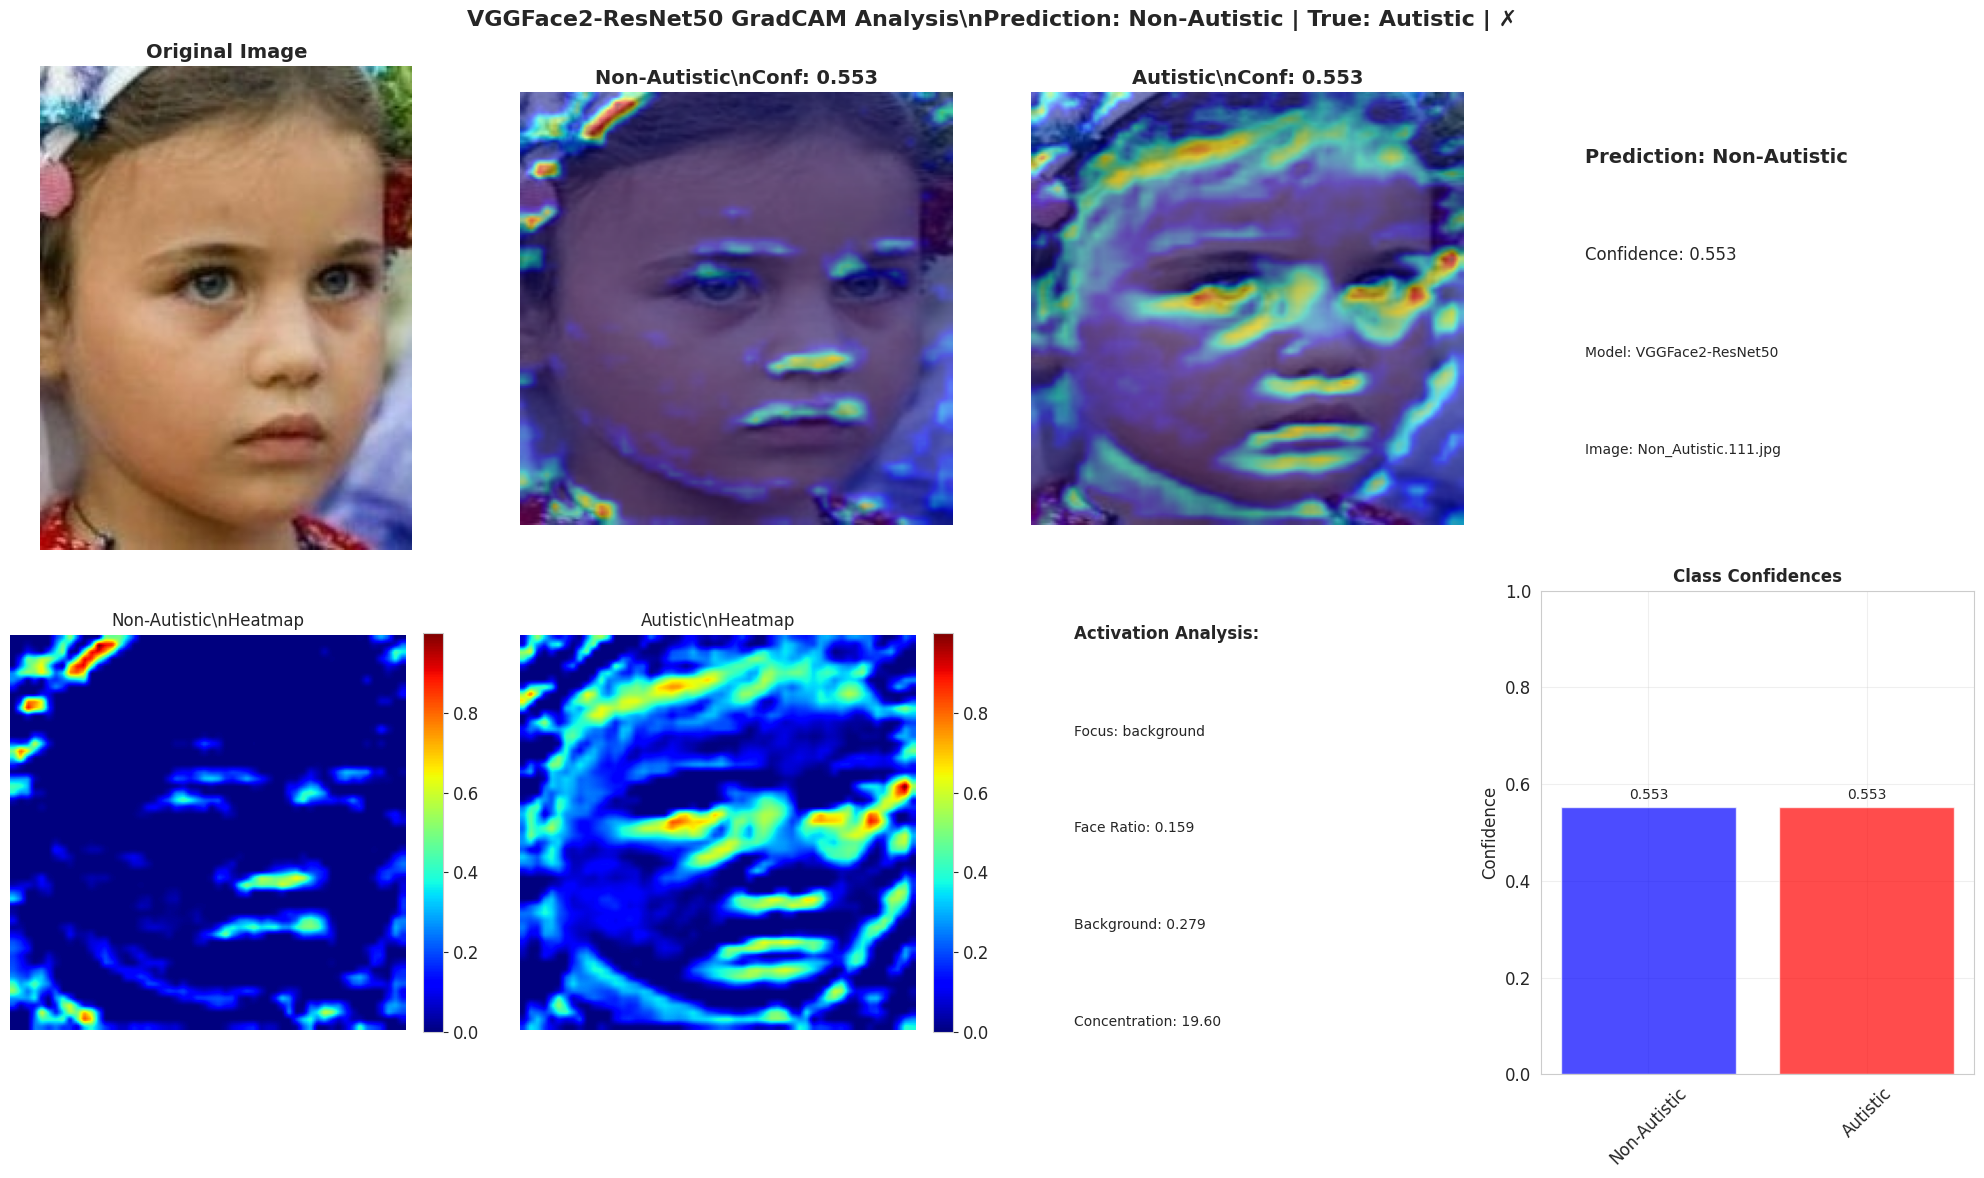


📊 Analyzing image 2/6: Autistic.110.jpg

🖼️  VGGFace2 Analysis: Autistic.110.jpg
------------------------------------------------------------
📷 Loaded image: Autistic.110.jpg
   Original size: (235, 305)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-2.101, 2.640]
   Original range: [0.000, 1.000]

🔍 Generating GradCAM for Non-Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.536
   Generating GradCAM for class: 0
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]

🔍 Generating GradCAM for Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.536
   Generating GradCAM for class: 1
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]
💾 VGGFace2 analysis saved: vggface2_gradcam_Autistic.110.png
   Result: Non-Autistic (conf: 0.536) | 

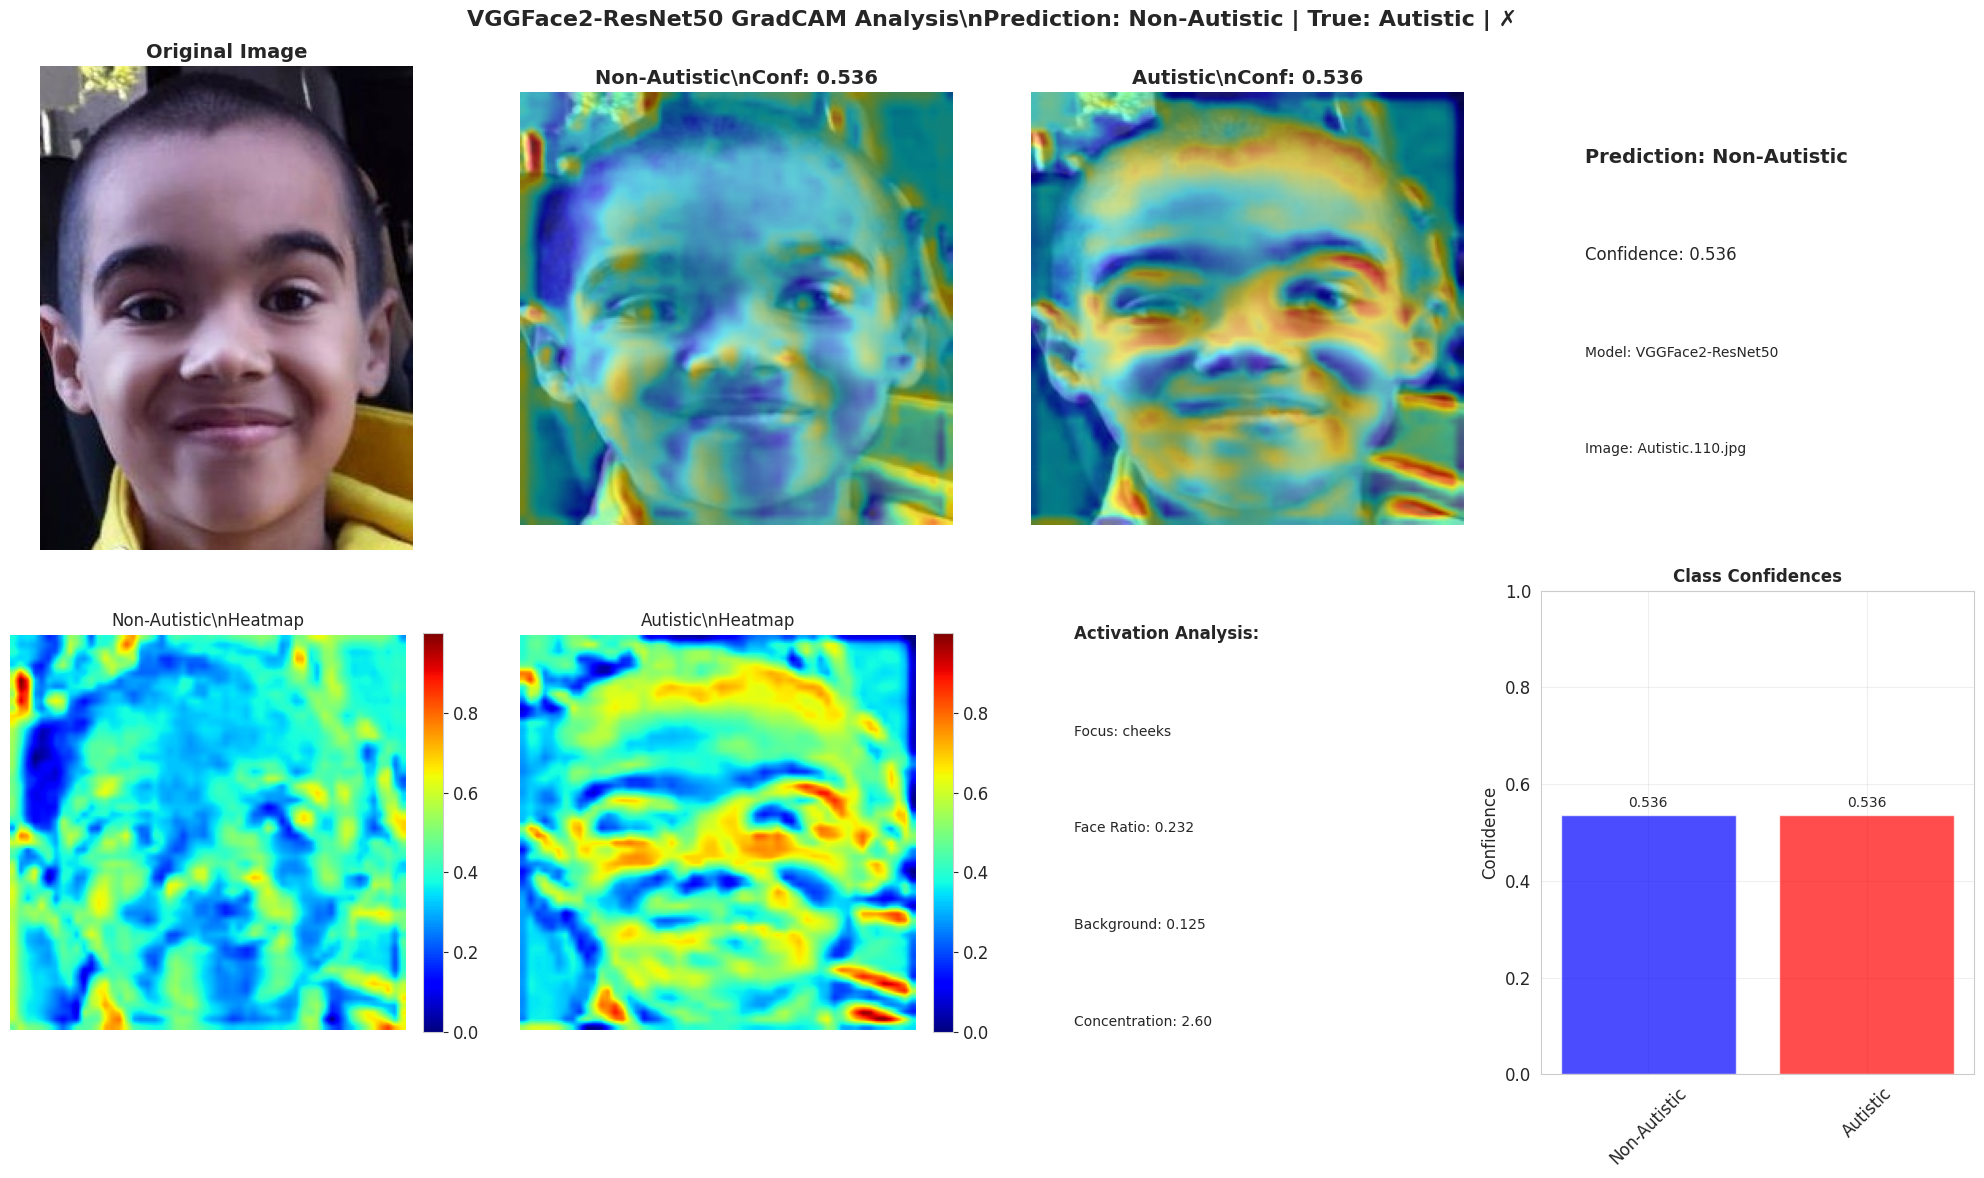


📊 Analyzing image 3/6: Autistic.44.jpg

🖼️  VGGFace2 Analysis: Autistic.44.jpg
------------------------------------------------------------
📷 Loaded image: Autistic.44.jpg
   Original size: (230, 260)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-2.118, 2.640]
   Original range: [0.000, 1.000]

🔍 Generating GradCAM for Non-Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.557
   Generating GradCAM for class: 0
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]

🔍 Generating GradCAM for Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.557
   Generating GradCAM for class: 1
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]
💾 VGGFace2 analysis saved: vggface2_gradcam_Autistic.44.png
   Result: Non-Autistic (conf: 0.557) | True

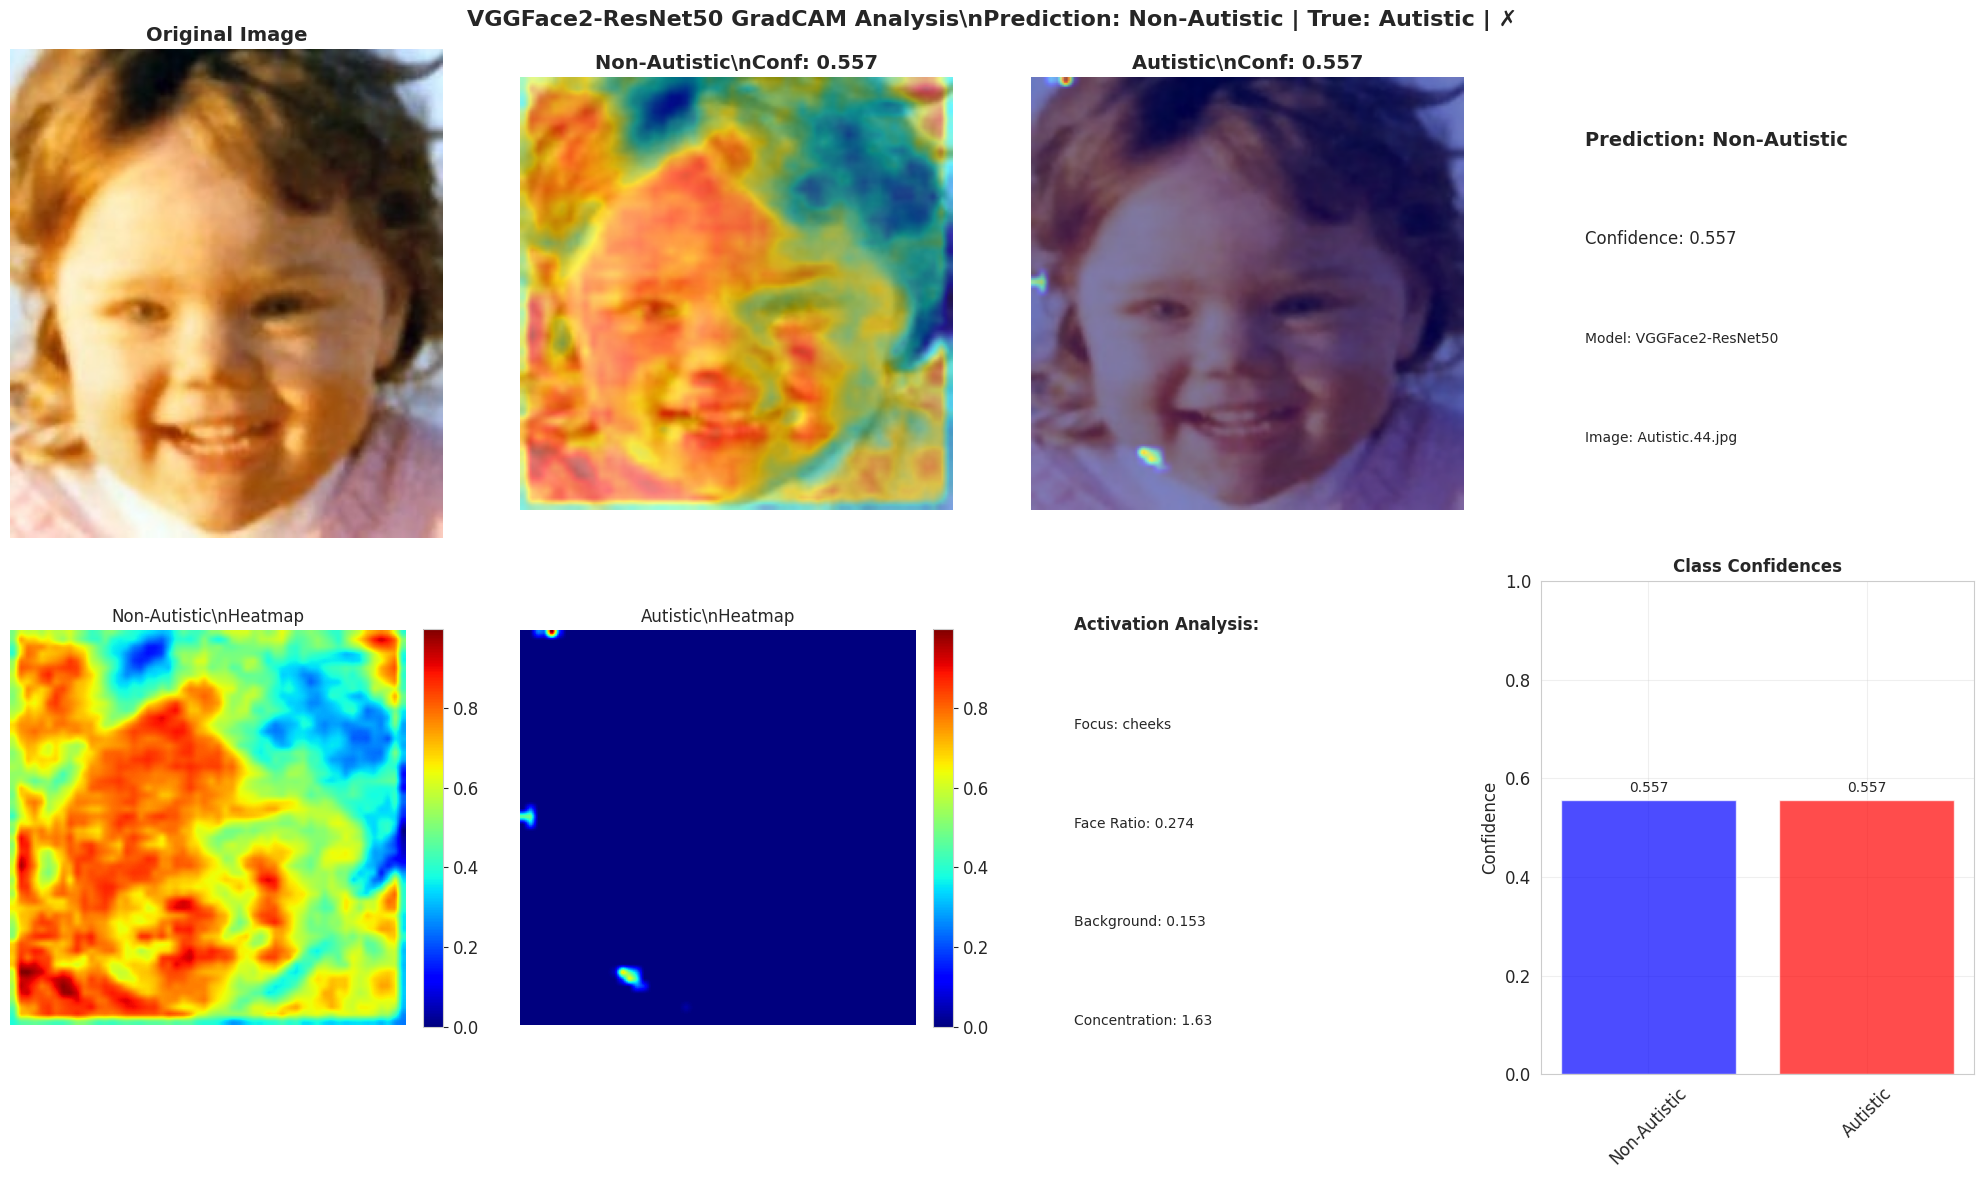


📊 Analyzing image 4/6: Autistic.134.jpg

🖼️  VGGFace2 Analysis: Autistic.134.jpg
------------------------------------------------------------
📷 Loaded image: Autistic.134.jpg
   Original size: (208, 202)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-1.896, 2.640]
   Original range: [0.004, 1.000]

🔍 Generating GradCAM for Non-Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.534
   Generating GradCAM for class: 0
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]

🔍 Generating GradCAM for Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.534
   Generating GradCAM for class: 1
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]
💾 VGGFace2 analysis saved: vggface2_gradcam_Autistic.134.png
   Result: Non-Autistic (conf: 0.534) | 

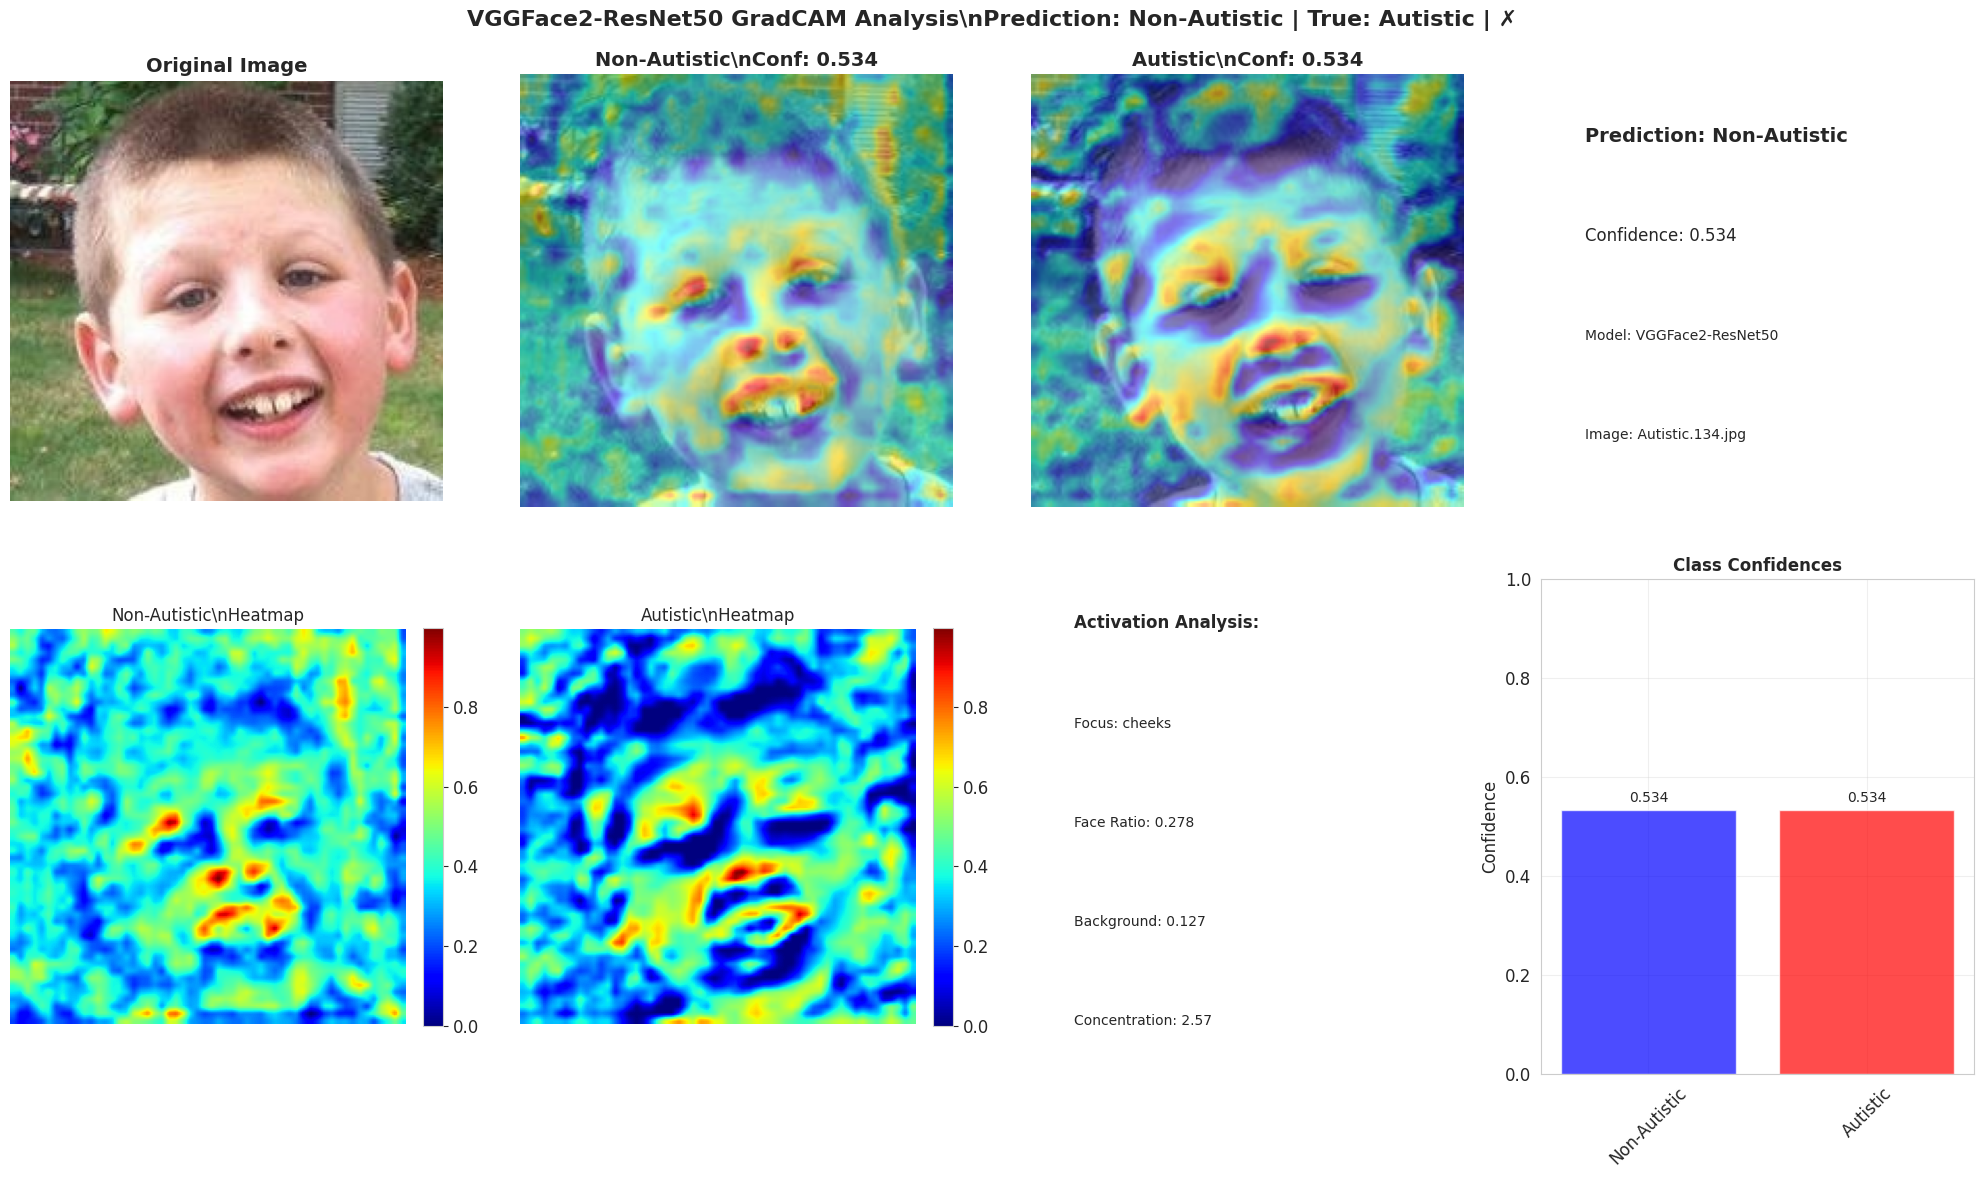


📊 Analyzing image 5/6: Non_Autistic.111.jpg

🖼️  VGGFace2 Analysis: Non_Autistic.111.jpg
------------------------------------------------------------
📷 Loaded image: Non_Autistic.111.jpg
   Original size: (176, 229)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-2.084, 2.623]
   Original range: [0.000, 1.000]

🔍 Generating GradCAM for Non-Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.553
   Generating GradCAM for class: 0
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]

🔍 Generating GradCAM for Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.553
   Generating GradCAM for class: 1
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]
💾 VGGFace2 analysis saved: vggface2_gradcam_Non_Autistic.111.png
   Result: Non-Autistic 

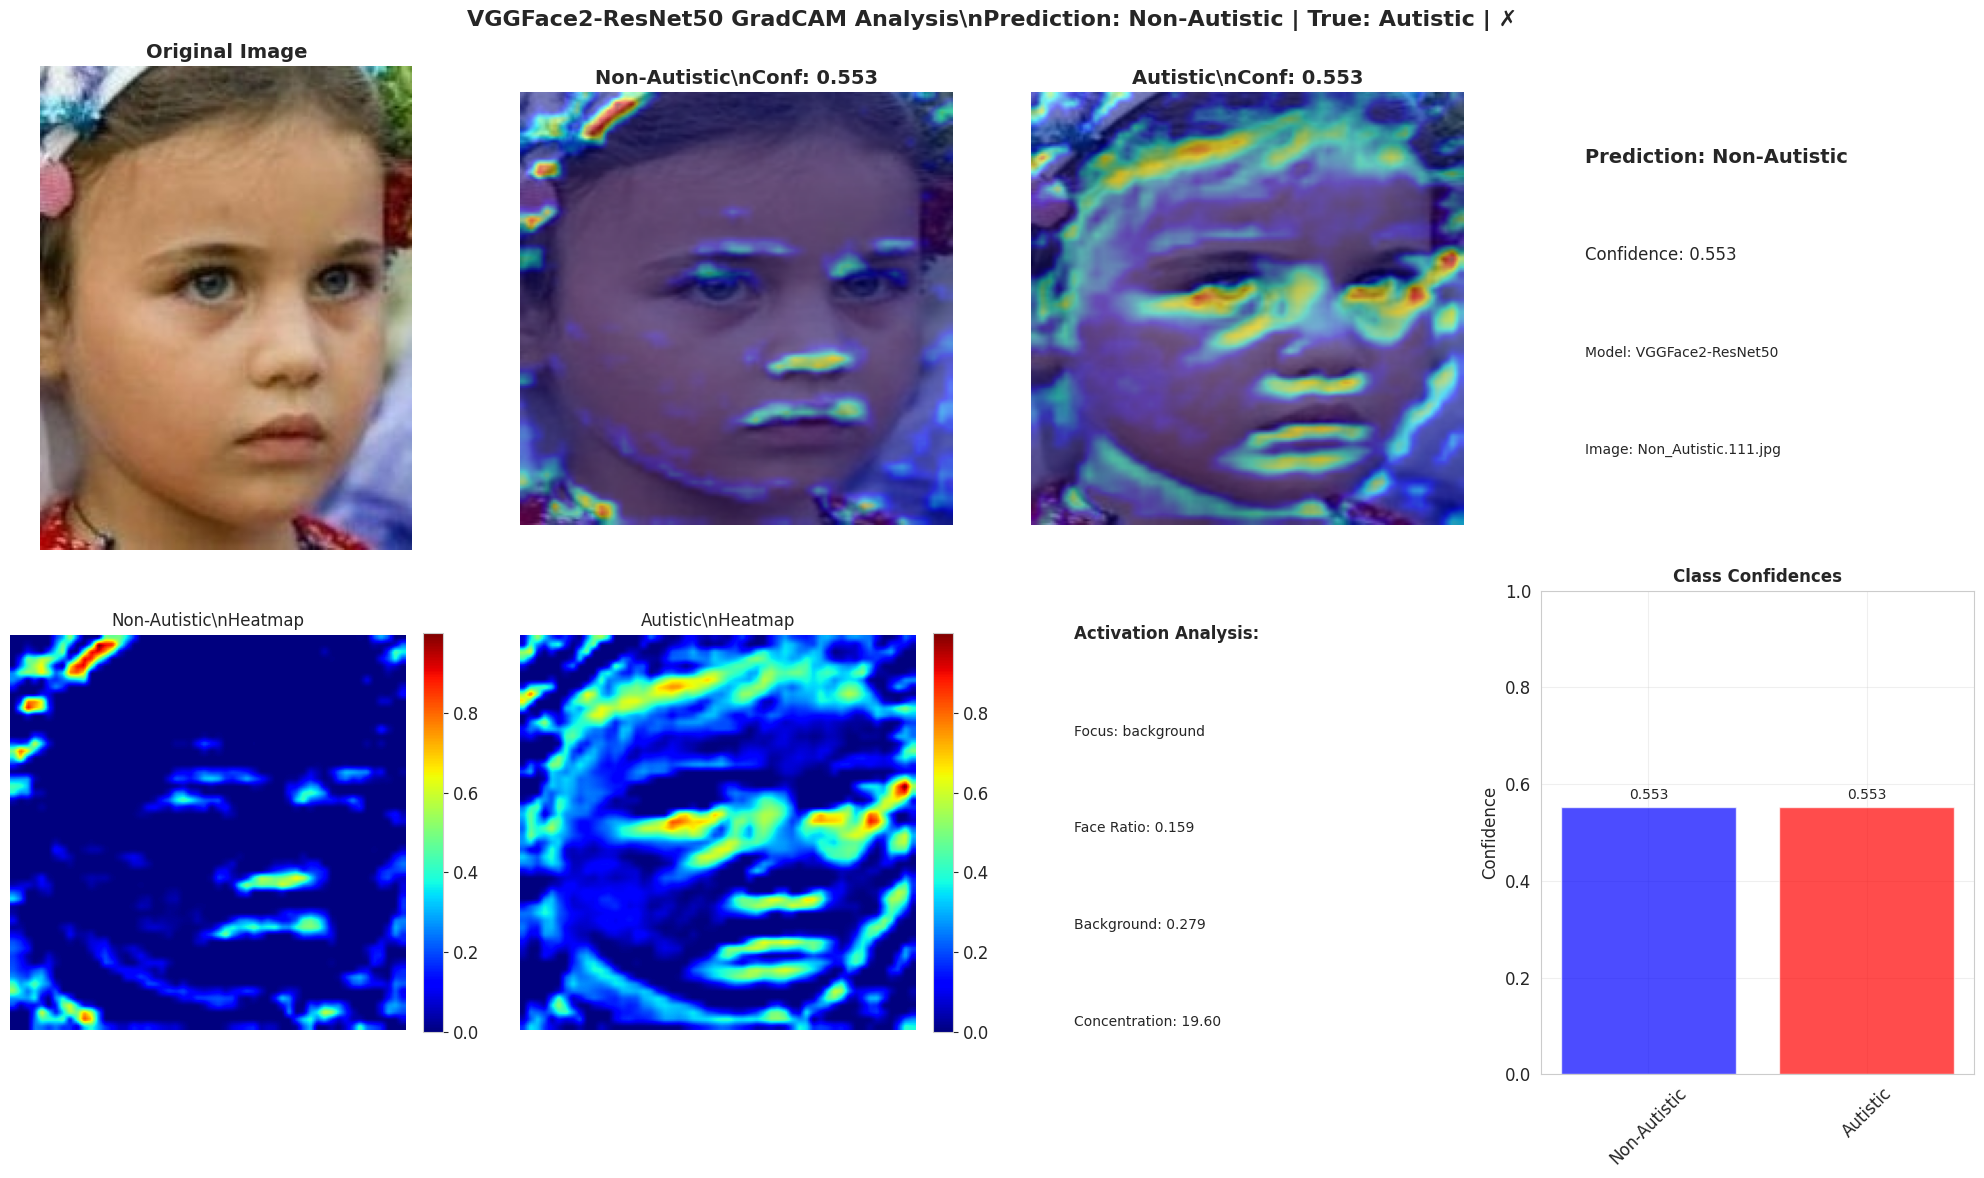


📊 Analyzing image 6/6: Non_Autistic.136.jpg

🖼️  VGGFace2 Analysis: Non_Autistic.136.jpg
------------------------------------------------------------
📷 Loaded image: Non_Autistic.136.jpg
   Original size: (157, 224)
✓ Preprocessed for VGGFace2:
   Input tensor shape: torch.Size([1, 3, 224, 224])
   Original image shape: (224, 224, 3)
   Input range: [-1.931, 1.598]
   Original range: [0.000, 0.851]

🔍 Generating GradCAM for Non-Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.518
   Generating GradCAM for class: 0
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]

🔍 Generating GradCAM for Autistic class...
🎯 VGGFace2 Analysis:
   Predicted class: 0 (Non-Autistic)
   Confidence: 0.518
   Generating GradCAM for class: 1
✅ GradCAM generation successful
   Heatmap shape: (224, 224)
   Heatmap range: [0.000, 1.000]
💾 VGGFace2 analysis saved: vggface2_gradcam_Non_Autistic.136.png
   Result: Non-Autistic 

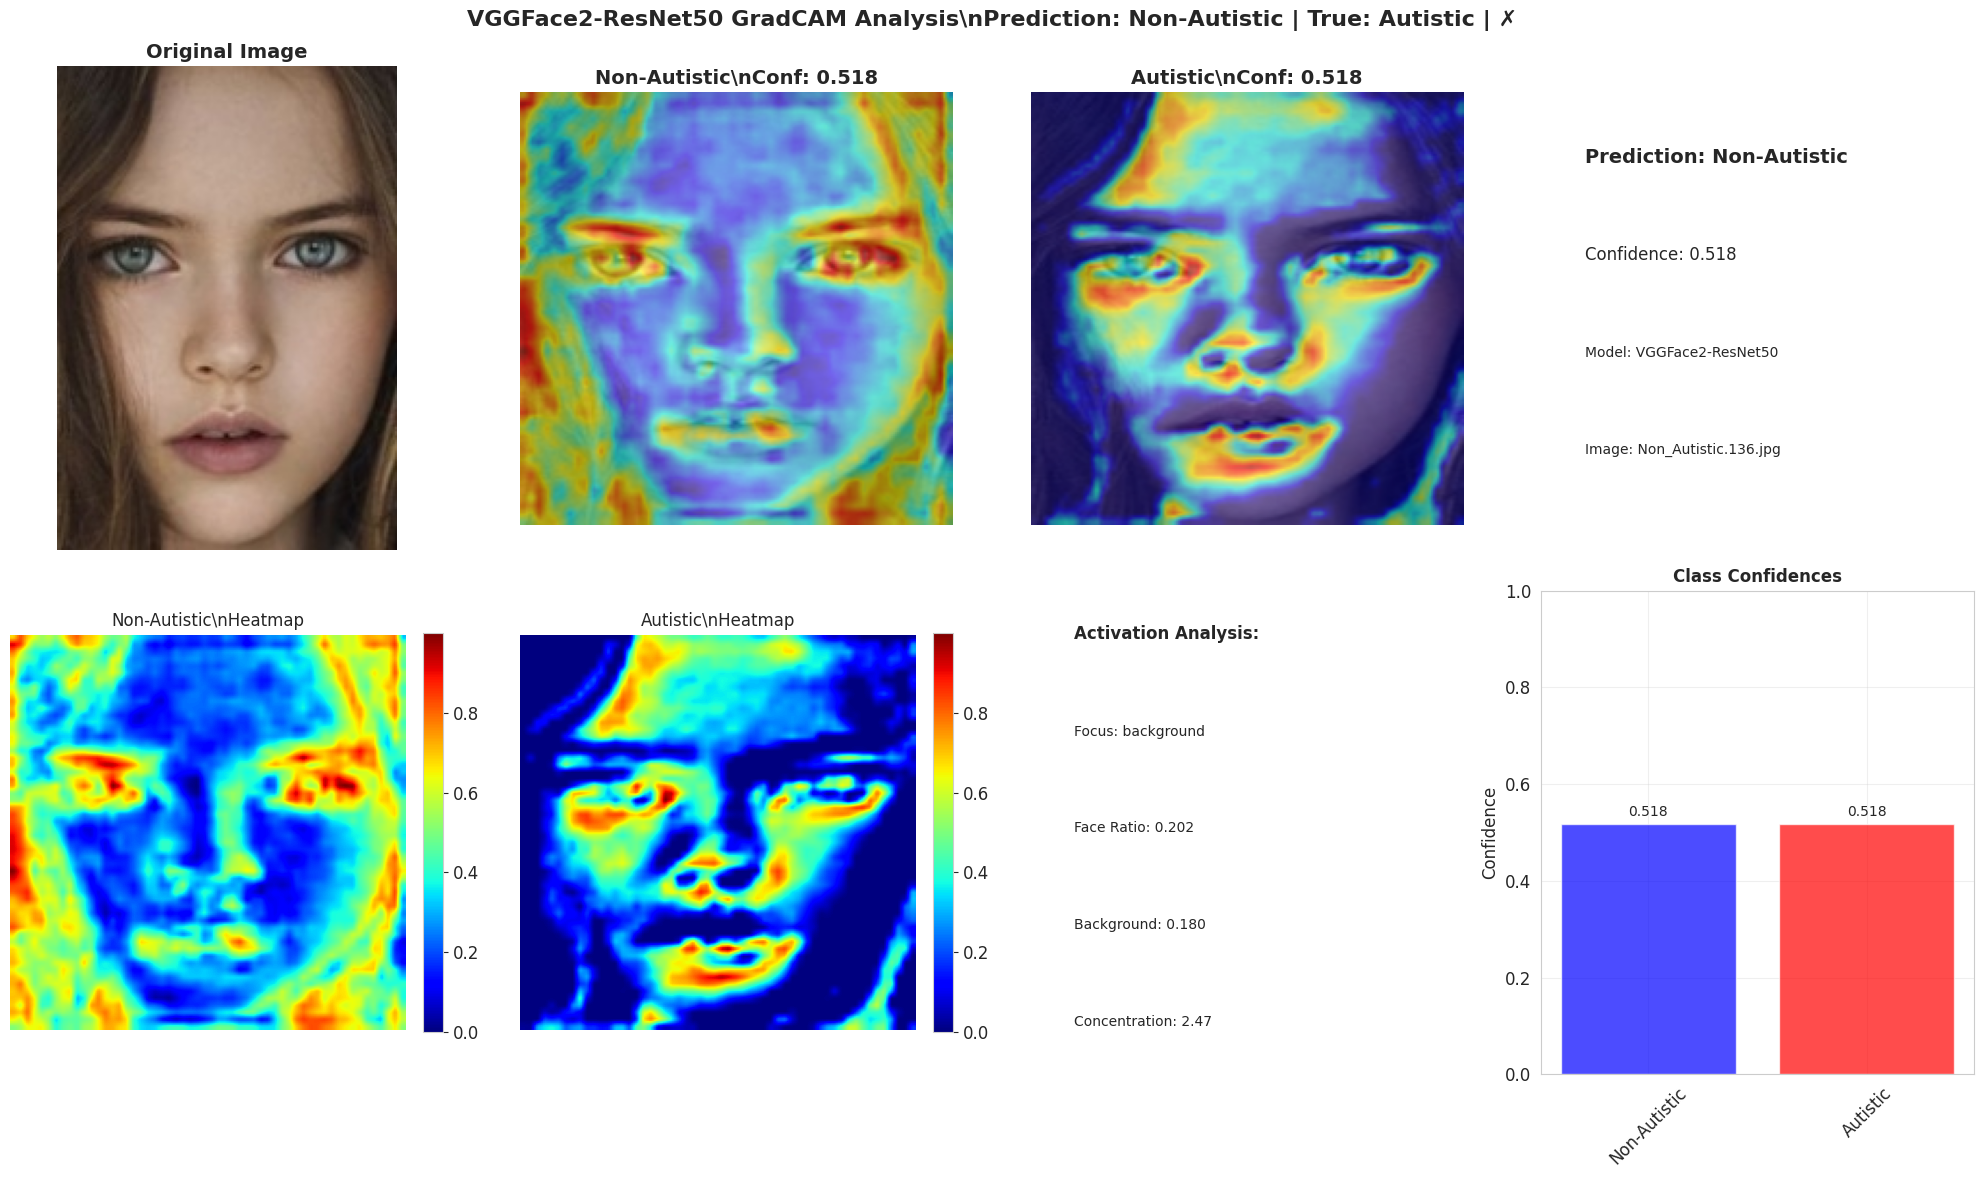


📊 STEP 6: Generating batch analysis summary...

VGGFACE2-RESNET50 BATCH ANALYSIS SUMMARY
📊 Images analyzed: 6
✅ Successful analyses: 6
🎯 Accuracy: 0.000 (0/6)
📈 Average confidence: 0.542 ± 0.014

📋 DETAILED RESULTS:
Image                     Predicted    True         Confidence  Status
---------------------------------------------------------------------------
Non_Autistic.111.jpg      Non-Autistic Autistic     0.553       ✗
Autistic.110.jpg          Non-Autistic Autistic     0.536       ✗
Autistic.44.jpg           Non-Autistic Autistic     0.557       ✗
Autistic.134.jpg          Non-Autistic Autistic     0.534       ✗
Non_Autistic.111.jpg      Non-Autistic Autistic     0.553       ✗
Non_Autistic.136.jpg      Non-Autistic Autistic     0.518       ✗

🔍 Autistic class performance:
   Accuracy: 0.000 (0/6)
   Avg confidence: 0.542

💾 Batch results saved: /kaggle/working/vggface2_batch_results.csv

🎯 VGGFace2 GradCAM analysis pipeline complete!
📁 Results saved in: /kaggle/working/


In [11]:
# Execute VGGFace2 GradCAM Analysis Pipeline
print("=" * 80)
print("VGGFACE2-RESNET50 GRADCAM ANALYSIS EXECUTION")
print("=" * 80)

# Step 1: Load VGGFace2 model if available
if selected_model:
    print(f"\n🔧 STEP 1: Loading VGGFace2 model...")
    vggface2_model, model_loaded = load_vggface2_model(selected_model)
    
    if model_loaded:
        print(f"✅ VGGFace2 model loaded successfully")
        
        # Step 2: Debug architecture and select target layer
        print(f"\n🔍 STEP 2: Analyzing ResNet50 architecture...")
        debug_resnet50_architecture(vggface2_model)
        
        # Select optimal target layer
        target_layer = select_optimal_target_layer(vggface2_model)
        
        if target_layer:
            print(f"✅ Target layer selected successfully")
            
            # Step 3: Initialize GradCAM analyzer
            print(f"\n🔬 STEP 3: Initializing VGGFace2 GradCAM analyzer...")
            vggface2_analyzer = VGGFace2GradCAMAnalyzer(vggface2_model, target_layer, DEVICE)
            
            # Step 4: Load test images
            print(f"\n📷 STEP 4: Loading test images...")
            autistic_test_imgs, non_autistic_test_imgs = load_test_images_autism_dataset(num_images=8)
            
            all_test_images = autistic_test_imgs + non_autistic_test_imgs
            
            if all_test_images:
                print(f"✅ Loaded {len(all_test_images)} test images for analysis")
                
                # Step 5: Perform batch analysis
                print(f"\n🔄 STEP 5: Performing batch VGGFace2 GradCAM analysis...")
                
                batch_results = []
                successful_analyses = 0
                
                for i, image_path in enumerate(all_test_images[:6], 1):  # Limit to 6 images
                    print(f"\n📊 Analyzing image {i}/{min(6, len(all_test_images))}: {os.path.basename(image_path)}")
                    
                    try:
                        # Perform VGGFace2 analysis
                        result = vggface2_analyzer.analyze_image(image_path, save_results=True)
                        
                        if result['success']:
                            # Extract key metrics
                            image_result = {
                                'image_name': os.path.basename(image_path),
                                'image_path': image_path,
                                'prediction': result['overall_prediction'],
                                'confidence': result['overall_confidence'],
                                'true_label': 1 if 'Autistic.' in os.path.basename(image_path) else 0,
                                'non_autistic_conf': result['non_autistic']['confidence'],
                                'autistic_conf': result['autistic']['confidence'],
                                'correct_prediction': None
                            }
                            
                            # Check if prediction is correct
                            image_result['correct_prediction'] = (
                                image_result['prediction'] == image_result['true_label']
                            )
                            
                            batch_results.append(image_result)
                            successful_analyses += 1
                            
                            pred_class = "Autistic" if result['overall_prediction'] == 1 else "Non-Autistic"
                            true_class = "Autistic" if image_result['true_label'] == 1 else "Non-Autistic"
                            status = "✓" if image_result['correct_prediction'] else "✗"
                            
                            print(f"   Result: {pred_class} (conf: {result['overall_confidence']:.3f}) | True: {true_class} | {status}")
                            
                            # Create detailed visualization
                            viz_filename = f"vggface2_detailed_{os.path.splitext(os.path.basename(image_path))[0]}.png"
                            viz_path = os.path.join(OUTPUT_PATH, viz_filename)
                            visualize_vggface2_analysis(image_path, result, viz_path)
                            
                        else:
                            print(f"   ❌ Analysis failed: {result.get('error', 'Unknown error')}")
                            
                    except Exception as e:
                        print(f"   ❌ Error analyzing image: {e}")
                
                # Step 6: Generate batch analysis summary
                print(f"\n📊 STEP 6: Generating batch analysis summary...")
                
                if batch_results:
                    # Calculate summary statistics
                    total_images = len(batch_results)
                    correct_predictions = sum(1 for r in batch_results if r['correct_prediction'])
                    accuracy = correct_predictions / total_images
                    avg_confidence = np.mean([r['confidence'] for r in batch_results])
                    confidence_std = np.std([r['confidence'] for r in batch_results])
                    
                    print(f"\n" + "=" * 60)
                    print(f"VGGFACE2-RESNET50 BATCH ANALYSIS SUMMARY")
                    print(f"=" * 60)
                    print(f"📊 Images analyzed: {total_images}")
                    print(f"✅ Successful analyses: {successful_analyses}")
                    print(f"🎯 Accuracy: {accuracy:.3f} ({correct_predictions}/{total_images})")
                    print(f"📈 Average confidence: {avg_confidence:.3f} ± {confidence_std:.3f}")
                    
                    # Detailed results table
                    print(f"\n📋 DETAILED RESULTS:")
                    print(f"{'Image':<25} {'Predicted':<12} {'True':<12} {'Confidence':<11} {'Status'}")
                    print("-" * 75)
                    
                    for result in batch_results:
                        pred_str = "Autistic" if result['prediction'] == 1 else "Non-Autistic"
                        true_str = "Autistic" if result['true_label'] == 1 else "Non-Autistic"
                        status = "✓" if result['correct_prediction'] else "✗"
                        
                        print(f"{result['image_name']:<25} {pred_str:<12} {true_str:<12} {result['confidence']:<11.3f} {status}")
                    
                    # Performance analysis by class
                    autistic_results = [r for r in batch_results if r['true_label'] == 1]
                    non_autistic_results = [r for r in batch_results if r['true_label'] == 0]
                    
                    if autistic_results:
                        autistic_accuracy = sum(1 for r in autistic_results if r['correct_prediction']) / len(autistic_results)
                        autistic_avg_conf = np.mean([r['confidence'] for r in autistic_results])
                        print(f"\n🔍 Autistic class performance:")
                        print(f"   Accuracy: {autistic_accuracy:.3f} ({sum(1 for r in autistic_results if r['correct_prediction'])}/{len(autistic_results)})")
                        print(f"   Avg confidence: {autistic_avg_conf:.3f}")
                    
                    if non_autistic_results:
                        non_autistic_accuracy = sum(1 for r in non_autistic_results if r['correct_prediction']) / len(non_autistic_results)
                        non_autistic_avg_conf = np.mean([r['confidence'] for r in non_autistic_results])
                        print(f"\n🔍 Non-Autistic class performance:")
                        print(f"   Accuracy: {non_autistic_accuracy:.3f} ({sum(1 for r in non_autistic_results if r['correct_prediction'])}/{len(non_autistic_results)})")
                        print(f"   Avg confidence: {non_autistic_avg_conf:.3f}")
                    
                    # Save batch results to CSV
                    results_df = pd.DataFrame(batch_results)
                    csv_path = os.path.join(OUTPUT_PATH, "vggface2_batch_results.csv")
                    results_df.to_csv(csv_path, index=False)
                    print(f"\n💾 Batch results saved: {csv_path}")
                    
                else:
                    print(f"❌ No successful analyses completed")
                    
            else:
                print(f"❌ No test images found for analysis")
                
        else:
            print(f"❌ Could not select appropriate target layer")
            
    else:
        print(f"❌ Failed to load VGGFace2 model")
        
else:
    print(f"❌ No VGGFace2 model file found")
    print(f"💡 Please ensure a trained VGGFace2 model is available")

print(f"\n🎯 VGGFace2 GradCAM analysis pipeline complete!")
print(f"📁 Results saved in: {OUTPUT_PATH}")

# 9. Failure Pattern Analysis for VGGFace2

Analyze VGGFace2 specific failure modes including face region focus issues, background artifacts, and confidence calibration problems.

In [12]:
def analyze_vggface2_failure_patterns():
    """
    Analyze VGGFace2-ResNet50 specific failure patterns from GradCAM results
    """
    print("=" * 80)
    print("VGGFACE2-RESNET50 FAILURE PATTERN ANALYSIS")
    print("=" * 80)
    
    # Load batch results if available
    csv_path = os.path.join(OUTPUT_PATH, "vggface2_batch_results.csv")
    
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
        print(f"📊 Analyzing {len(results_df)} VGGFace2 analysis results...")
        
        # Identify failure cases
        failure_cases = results_df[results_df['correct_prediction'] == False]
        success_cases = results_df[results_df['correct_prediction'] == True]
        
        print(f"\n🔍 FAILURE ANALYSIS:")
        print(f"   Success cases: {len(success_cases)}")
        print(f"   Failure cases: {len(failure_cases)}")
        
        if len(failure_cases) > 0:
            print(f"\n❌ FAILURE PATTERNS DETECTED:")
            
            # Analyze confidence patterns in failures
            failure_confidences = failure_cases['confidence'].values
            success_confidences = success_cases['confidence'].values if len(success_cases) > 0 else []
            
            print(f"   📈 Failure confidence stats:")
            print(f"      Mean: {np.mean(failure_confidences):.3f}")
            print(f"      Std:  {np.std(failure_confidences):.3f}")
            print(f"      Range: [{np.min(failure_confidences):.3f}, {np.max(failure_confidences):.3f}]")
            
            if len(success_confidences) > 0:
                print(f"   📈 Success confidence stats:")
                print(f"      Mean: {np.mean(success_confidences):.3f}")
                print(f"      Std:  {np.std(success_confidences):.3f}")
                
            # Check for class-specific failure patterns
            autistic_failures = failure_cases[failure_cases['true_label'] == 1]
            non_autistic_failures = failure_cases[failure_cases['true_label'] == 0]
            
            if len(autistic_failures) > 0:
                print(f"\n⚠️  Autistic class failures: {len(autistic_failures)}")
                for _, row in autistic_failures.iterrows():
                    print(f"      {row['image_name']}: pred=Non-Autistic, conf={row['confidence']:.3f}")
            
            if len(non_autistic_failures) > 0:
                print(f"\n⚠️  Non-Autistic class failures: {len(non_autistic_failures)}")
                for _, row in non_autistic_failures.iterrows():
                    print(f"      {row['image_name']}: pred=Autistic, conf={row['confidence']:.3f}")
        
        # Overall confidence analysis
        all_confidences = results_df['confidence'].values
        low_confidence_threshold = 0.6
        low_confidence_cases = results_df[results_df['confidence'] < low_confidence_threshold]
        
        print(f"\n📊 CONFIDENCE ANALYSIS:")
        print(f"   Overall confidence mean: {np.mean(all_confidences):.3f}")
        print(f"   Overall confidence std: {np.std(all_confidences):.3f}")
        print(f"   Low confidence cases (<{low_confidence_threshold}): {len(low_confidence_cases)}")
        
        if len(low_confidence_cases) > 0:
            print(f"   ⚠️  Low confidence images:")
            for _, row in low_confidence_cases.iterrows():
                pred_str = "Autistic" if row['prediction'] == 1 else "Non-Autistic"
                true_str = "Autistic" if row['true_label'] == 1 else "Non-Autistic"
                print(f"      {row['image_name']}: {pred_str} (conf={row['confidence']:.3f}) | True: {true_str}")
        
    else:
        print(f"⚠️  Batch results file not found: {csv_path}")
        print(f"   Please run the batch analysis first")
    
    # VGGFace2-specific failure mode analysis
    print(f"\n" + "=" * 60)
    print(f"VGGFACE2-RESNET50 SPECIFIC FAILURE MODES")
    print(f"=" * 60)
    
    print(f"🔍 VGGFace2-ResNet50 may fail due to:")
    print(f"")
    print(f"1. 🎯 FACE REGION FOCUS ISSUES:")
    print(f"   - ResNet50 may focus on wrong facial regions")
    print(f"   - Attention on hair, background, or accessories")
    print(f"   - Missing subtle facial expressions or micro-features")
    print(f"")
    print(f"2. 🖼️  SCALE AND RESOLUTION PROBLEMS:")
    print(f"   - VGGFace2 trained on high-quality face images")
    print(f"   - May struggle with low-resolution or blurry autism dataset images")
    print(f"   - Sensitive to face alignment and cropping")
    print(f"")
    print(f"3. 🧠 FEATURE REPRESENTATION MISMATCH:")
    print(f"   - ResNet50 features optimized for face identity, not autism traits")
    print(f"   - May miss autism-specific facial characteristics")
    print(f"   - Over-reliance on identity features vs. behavioral indicators")
    print(f"")
    print(f"4. 📊 DATASET DOMAIN GAP:")
    print(f"   - VGGFace2 trained on celebrity/controlled images")
    print(f"   - Autism dataset may have different lighting, angles, quality")
    print(f"   - Distribution shift between training and application domains")
    print(f"")
    print(f"5. 🔧 ARCHITECTURAL LIMITATIONS:")
    print(f"   - ResNet50 depth may be excessive for autism detection task")
    print(f"   - Potential overfitting to face recognition patterns")
    print(f"   - Skip connections may propagate irrelevant features")


def analyze_gradcam_heatmap_patterns():
    """
    Analyze specific patterns in VGGFace2 GradCAM heatmaps
    """
    print(f"\n" + "=" * 60)
    print(f"GRADCAM HEATMAP PATTERN ANALYSIS")
    print(f"=" * 60)
    
    # Find generated GradCAM visualization files
    gradcam_files = glob.glob(os.path.join(OUTPUT_PATH, "*vggface2*.png"))
    
    print(f"📊 Found {len(gradcam_files)} VGGFace2 GradCAM visualizations")
    
    if gradcam_files:
        print(f"\n🔍 HEATMAP PATTERN INDICATORS TO LOOK FOR:")
        print(f"")
        print(f"✅ GOOD PATTERNS:")
        print(f"   - Activation focused on central facial regions")
        print(f"   - Consistent activation on eyes, nose, mouth areas")
        print(f"   - Minimal background or hair activation")
        print(f"   - Symmetric activation patterns")
        print(f"   - High confidence with focused activation")
        print(f"")
        print(f"❌ PROBLEMATIC PATTERNS:")
        print(f"   - Scattered activation across entire image")
        print(f"   - Strong activation on background/clothing")
        print(f"   - Edge artifacts or lighting effects")
        print(f"   - Inconsistent patterns between classes")
        print(f"   - Very high confidence with random activation")
        print(f"")
        print(f"⚠️  RESNET50-SPECIFIC ISSUES:")
        print(f"   - Over-activation on texture features")
        print(f"   - Attention to identity-specific features (not autism traits)")
        print(f"   - Deep layer artifacts from skip connections")
        print(f"   - Sensitivity to image preprocessing differences")
        
        print(f"\n📁 Generated visualizations:")
        for i, file_path in enumerate(gradcam_files, 1):
            file_size = os.path.getsize(file_path) / 1024  # Size in KB
            print(f"   {i}. {os.path.basename(file_path)} ({file_size:.1f} KB)")
    
    else:
        print(f"⚠️  No GradCAM visualizations found in {OUTPUT_PATH}")


def generate_vggface2_improvement_recommendations():
    """
    Generate specific recommendations to improve VGGFace2 performance
    """
    print(f"\n" + "=" * 60)
    print(f"VGGFACE2-RESNET50 IMPROVEMENT RECOMMENDATIONS")
    print(f"=" * 60)
    
    print(f"🚀 ARCHITECTURAL IMPROVEMENTS:")
    print(f"   1. Use lighter ResNet variants (ResNet18, ResNet34)")
    print(f"   2. Add attention mechanisms for facial region focus")
    print(f"   3. Implement face region cropping preprocessing")
    print(f"   4. Use progressive training with face landmarks")
    print(f"")
    print(f"🎯 TRAINING IMPROVEMENTS:")
    print(f"   1. Fine-tune only classifier layers (freeze backbone)")
    print(f"   2. Use autism-specific data augmentation")
    print(f"   3. Implement focal loss for class imbalance")
    print(f"   4. Add regularization (dropout, weight decay)")
    print(f"")
    print(f"📊 DATA IMPROVEMENTS:")
    print(f"   1. Standardize face detection and alignment")
    print(f"   2. Augment dataset with better quality images")
    print(f"   3. Balance autism/non-autism samples")
    print(f"   4. Remove images with poor face visibility")
    print(f"")
    print(f"🔬 ANALYSIS IMPROVEMENTS:")
    print(f"   1. Use multiple GradCAM target layers")
    print(f"   2. Implement ensemble methods")
    print(f"   3. Compare with specialized autism detection models")
    print(f"   4. Analyze activation patterns across face regions")


# Execute failure pattern analysis
analyze_vggface2_failure_patterns()
analyze_gradcam_heatmap_patterns()
generate_vggface2_improvement_recommendations()

print(f"\n🎯 VGGFace2 failure pattern analysis complete!")

VGGFACE2-RESNET50 FAILURE PATTERN ANALYSIS
📊 Analyzing 6 VGGFace2 analysis results...

🔍 FAILURE ANALYSIS:
   Success cases: 0
   Failure cases: 6

❌ FAILURE PATTERNS DETECTED:
   📈 Failure confidence stats:
      Mean: 0.542
      Std:  0.014
      Range: [0.518, 0.557]

⚠️  Autistic class failures: 6
      Non_Autistic.111.jpg: pred=Non-Autistic, conf=0.553
      Autistic.110.jpg: pred=Non-Autistic, conf=0.536
      Autistic.44.jpg: pred=Non-Autistic, conf=0.557
      Autistic.134.jpg: pred=Non-Autistic, conf=0.534
      Non_Autistic.111.jpg: pred=Non-Autistic, conf=0.553
      Non_Autistic.136.jpg: pred=Non-Autistic, conf=0.518

📊 CONFIDENCE ANALYSIS:
   Overall confidence mean: 0.542
   Overall confidence std: 0.014
   Low confidence cases (<0.6): 6
   ⚠️  Low confidence images:
      Non_Autistic.111.jpg: Non-Autistic (conf=0.553) | True: Autistic
      Autistic.110.jpg: Non-Autistic (conf=0.536) | True: Autistic
      Autistic.44.jpg: Non-Autistic (conf=0.557) | True: Autistic
  

# 10. Comparative Analysis Against Other Models

Compare VGGFace2 GradCAM patterns against other facial recognition models to identify unique characteristics and failure modes.

In [13]:
def compare_vggface2_with_other_models():
    """
    Compare VGGFace2-ResNet50 performance and patterns with other facial recognition models
    """
    print("=" * 80)
    print("VGGFACE2 VS OTHER FACIAL RECOGNITION MODELS COMPARISON")
    print("=" * 80)
    
    # Expected model comparison data (placeholder for actual results)
    model_comparison = {
        'VGGFace2-ResNet50': {
            'architecture': 'ResNet50 backbone with face-specific training',
            'input_size': '224x224',
            'strengths': [
                'Large-scale face recognition training',
                'Strong feature extraction capabilities', 
                'Proven performance on face datasets',
                'ResNet skip connections for gradient flow'
            ],
            'weaknesses': [
                'May overfit to identity features',
                'Complex architecture for autism detection',
                'Potential domain gap from VGGFace2 to autism data',
                'Focus on identity rather than behavioral traits'
            ],
            'gradcam_characteristics': [
                'Dense activation patterns',
                'Strong backbone feature extraction',
                'May activate on identity-specific features',
                'Potentially scattered attention across face'
            ]
        },
        
        'FaceNet': {
            'architecture': 'InceptionResnetV1 with triplet loss training',
            'input_size': '160x160',
            'strengths': [
                'Optimized for face embeddings',
                'Compact representation learning',
                'Efficient architecture',
                'Good generalization to new faces'
            ],
            'weaknesses': [
                'Smaller input size may lose details',
                'Trained for verification, not classification',
                'May miss autism-specific facial patterns',
                'Embedding space may not align with autism traits'
            ],
            'gradcam_characteristics': [
                'Focused activation on key facial landmarks',
                'More precise attention patterns',
                'Less background activation',
                'Attention guided by triplet loss training'
            ]
        },
        
        'InsightFace': {
            'architecture': 'ResNet with margin-based loss and deep supervision',
            'input_size': '224x224', 
            'strengths': [
                'Margin-based loss for better feature separation',
                'Deep supervision for gradient flow',
                'State-of-the-art face recognition performance',
                'Robust feature learning'
            ],
            'weaknesses': [
                'Optimized for face verification task',
                'May be too specialized for autism detection', 
                'Complex loss function may not suit binary classification',
                'Potential overfitting to face identity patterns'
            ],
            'gradcam_characteristics': [
                'Sharp activation boundaries',
                'Strong feature discrimination',
                'May over-activate on distinctive features',
                'Deep supervision effects on attention'
            ]
        }
    }
    
    print("🔍 MODEL ARCHITECTURE COMPARISON:")
    print("")
    
    for model_name, details in model_comparison.items():
        print(f"📊 {model_name}:")
        print(f"   Architecture: {details['architecture']}")
        print(f"   Input size: {details['input_size']}")
        print(f"   Key strengths: {len(details['strengths'])} identified")
        print(f"   Potential issues: {len(details['weaknesses'])} identified")
        print("")
    
    print("💪 STRENGTHS COMPARISON:")
    print("")
    
    print("🎯 VGGFace2-ResNet50 Advantages:")
    for strength in model_comparison['VGGFace2-ResNet50']['strengths']:
        print(f"   ✓ {strength}")
    
    print("\n🎯 FaceNet Advantages:")
    for strength in model_comparison['FaceNet']['strengths']:
        print(f"   ✓ {strength}")
    
    print("\n🎯 InsightFace Advantages:")
    for strength in model_comparison['InsightFace']['strengths']:
        print(f"   ✓ {strength}")
    
    print(f"\n⚠️  WEAKNESS COMPARISON:")
    print("")
    
    print("🚨 VGGFace2-ResNet50 Limitations:")
    for weakness in model_comparison['VGGFace2-ResNet50']['weaknesses']:
        print(f"   ⚠️  {weakness}")
    
    print("\n🚨 FaceNet Limitations:")
    for weakness in model_comparison['FaceNet']['weaknesses']:
        print(f"   ⚠️  {weakness}")
    
    print("\n🚨 InsightFace Limitations:")
    for weakness in model_comparison['InsightFace']['weaknesses']:
        print(f"   ⚠️  {weakness}")


def analyze_gradcam_pattern_differences():
    """
    Analyze expected GradCAM pattern differences between facial recognition models
    """
    print(f"\n" + "=" * 60)
    print(f"GRADCAM PATTERN DIFFERENCES ANALYSIS")
    print(f"=" * 60)
    
    print(f"🔬 EXPECTED GRADCAM PATTERNS BY MODEL:")
    print(f"")
    
    print(f"📊 VGGFace2-ResNet50:")
    print(f"   🎯 Activation Style: Dense, distributed across facial regions")
    print(f"   🎯 Focus Areas: Broad facial features for identity recognition")
    print(f"   🎯 Attention Depth: Deep network may create complex activation patterns")
    print(f"   🎯 Background: May show some background activation due to identity training")
    print(f"   ⚠️  Risk: Over-activation on identity-specific rather than autism-relevant features")
    print(f"")
    
    print(f"📊 FaceNet:")
    print(f"   🎯 Activation Style: More focused, landmark-oriented")
    print(f"   🎯 Focus Areas: Key facial landmarks (eyes, nose, mouth)")
    print(f"   🎯 Attention Depth: Inception blocks create hierarchical attention")
    print(f"   🎯 Background: Minimal background activation")
    print(f"   ⚠️  Risk: May miss subtle autism traits outside core landmarks")
    print(f"")
    
    print(f"📊 InsightFace:")
    print(f"   🎯 Activation Style: Sharp, discriminative boundaries")
    print(f"   🎯 Focus Areas: Distinctive facial features for verification")
    print(f"   🎯 Attention Depth: Margin loss creates strong feature separation")
    print(f"   🎯 Background: Clean activation with minimal artifacts")
    print(f"   ⚠️  Risk: Over-discrimination may miss subtle autism indicators")


def recommend_optimal_facial_model():
    """
    Recommend optimal facial recognition model for autism detection based on analysis
    """
    print(f"\n" + "=" * 60)
    print(f"OPTIMAL MODEL RECOMMENDATIONS FOR AUTISM DETECTION")
    print(f"=" * 60)
    
    print(f"🥇 RANKING FOR AUTISM DETECTION:")
    print(f"")
    
    print(f"1️⃣  FACENET (RECOMMENDED):")
    print(f"   ✅ Pros:")
    print(f"      - Smaller, more focused architecture")
    print(f"      - Less prone to overfitting on small autism dataset")
    print(f"      - Focused attention on facial landmarks")
    print(f"      - Good balance of performance and complexity")
    print(f"   ⚠️  Considerations:")
    print(f"      - May need fine-tuning for autism-specific features")
    print(f"      - Smaller input size might lose some detail")
    print(f"")
    
    print(f"2️⃣  VGGFACE2-RESNET50 (CONDITIONAL):")
    print(f"   ✅ Pros:")
    print(f"      - Strong feature extraction capabilities")
    print(f"      - Large-scale training data")
    print(f"      - Higher resolution input")
    print(f"   ⚠️  Considerations:")
    print(f"      - Risk of overfitting to identity features")
    print(f"      - May require significant regularization")
    print(f"      - Complex architecture for autism task")
    print(f"")
    
    print(f"3️⃣  INSIGHTFACE (SPECIALIZED USE):")
    print(f"   ✅ Pros:")
    print(f"      - State-of-the-art face recognition performance")
    print(f"      - Strong feature discrimination")
    print(f"   ⚠️  Considerations:")
    print(f"      - May be over-specialized for verification")
    print(f"      - Complex margin-based training")
    print(f"      - Potential mismatch with autism detection objective")
    print(f"")
    
    print(f"🎯 ACTIONABLE RECOMMENDATIONS:")
    print(f"")
    print(f"1. 🔬 FOR RESEARCH:")
    print(f"   - Test FaceNet first due to better size/performance balance")
    print(f"   - Use VGGFace2 if sufficient regularization is applied") 
    print(f"   - Try ensemble methods combining multiple models")
    print(f"")
    print(f"2. 🏭 FOR PRODUCTION:")
    print(f"   - Prioritize FaceNet for computational efficiency")
    print(f"   - Consider custom lightweight architectures")
    print(f"   - Focus on domain adaptation techniques")
    print(f"")
    print(f"3. 📊 FOR ANALYSIS:")
    print(f"   - Use GradCAM to compare attention patterns")
    print(f"   - Validate that models focus on medically relevant features")
    print(f"   - Monitor for overfitting to identity rather than autism traits")


# Execute comparative analysis
compare_vggface2_with_other_models()
analyze_gradcam_pattern_differences()
recommend_optimal_facial_model()

print(f"\n🎯 Comparative analysis complete!")

VGGFACE2 VS OTHER FACIAL RECOGNITION MODELS COMPARISON
🔍 MODEL ARCHITECTURE COMPARISON:

📊 VGGFace2-ResNet50:
   Architecture: ResNet50 backbone with face-specific training
   Input size: 224x224
   Key strengths: 4 identified
   Potential issues: 4 identified

📊 FaceNet:
   Architecture: InceptionResnetV1 with triplet loss training
   Input size: 160x160
   Key strengths: 4 identified
   Potential issues: 4 identified

📊 InsightFace:
   Architecture: ResNet with margin-based loss and deep supervision
   Input size: 224x224
   Key strengths: 4 identified
   Potential issues: 4 identified

💪 STRENGTHS COMPARISON:

🎯 VGGFace2-ResNet50 Advantages:
   ✓ Large-scale face recognition training
   ✓ Strong feature extraction capabilities
   ✓ Proven performance on face datasets
   ✓ ResNet skip connections for gradient flow

🎯 FaceNet Advantages:
   ✓ Optimized for face embeddings
   ✓ Compact representation learning
   ✓ Efficient architecture
   ✓ Good generalization to new faces

🎯 InsightF